In [1]:
"""
GIFTED PROJECT

Written by Corrado Caudek (2023-05-04)

"""


import datetime

now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-04 21:39:41


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [2]:
# Import modules

# warning settings
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import arviz as az
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

# print(pickle.format_version)


/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The hddm version is 0.9.7


In [3]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, "wb") as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, "rb"))
    return model


hddm.load1 = load1

In [4]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(data.reset_index(), lsuffix="_sampled")
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(
    model, groupby=None, samples=500, append_data=False, progress_bar=True
):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = (
            (name, model.data.ix[obs["node"].value.index])
            for name, obs in model.iter_observeds()
        )
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, "random"):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data
        )
        results[name] = pd.concat(
            datasets, names=["sample"], keys=list(range(len(datasets)))
        )

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=["node"])

In [5]:
pwd

'/Users/corrado/_repositories/gifted/scripts/Python'

In [21]:
# load accuracy-coded data ('response' column represents accuracy: 1=rich response; 0=not rich response) 
data = hddm.load_csv("input4hddmrl.csv")

In [22]:
print("There are %d participants" % data["subj_idx"].nunique())

There are 83 participants


In [23]:
data.head()

subj_id  \
0  an_la_2011_3_2_m   
1  an_la_2011_3_2_m   
2  an_la_2011_3_2_m   
3  an_la_2011_3_2_m   
4  an_la_2011_3_2_m   

                                                                     code_psytoolkit  \
0  PRL_neutro_gifted_B.2022-06-09-1127.data.0722927f-81d0-4831-91c2-c62e36fb6053.txt   
1  PRL_neutro_gifted_B.2022-06-09-1127.data.0722927f-81d0-4831-91c2-c62e36fb6053.txt   
2  PRL_neutro_gifted_B.2022-06-09-1127.data.0722927f-81d0-4831-91c2-c62e36fb6053.txt   
3  PRL_neutro_gifted_B.2022-06-09-1127.data.0722927f-81d0-4831-91c2-c62e36fb6053.txt   
4  PRL_neutro_gifted_B.2022-06-09-1127.data.0722927f-81d0-4831-91c2-c62e36fb6053.txt   

   anno_nascita  mese  giorno sex        time_start          time_end  \
0          2011     3       2   m  2022-06-09-11-15  2022-06-09-11-27   
1          2011     3       2   m  2022-06-09-11-15  2022-06-09-11-27   
2          2011     3       2   m  2022-06-09-11-15  2022-06-09-11-27   
3          2011     3       2   m  2022-06-09-11-15  2022-06-09-11-27   
4          2011     3       2   m  2022-06-09-11-15  2022-06-09-11-27   

   time_total  epoch  ...     rt  intertrial_delay  resp  trial feedback  \
0          12      1  ...  0.738              1500    dx      1        0   
1          12      1  ...  1.555              2500    sx      2        1   
2          12      1  ...  0.749              1500    sx      3        1   
3          12      1  ...  0.736              1500    sx      4        1   
4          12      1  ...  0.731              1000    sx      5        1   

   is_target_chosen  response  split_by  subj_idx  q_init  
0               1.0       1.0       1.0        12     0.5  
1               1.0       1.0       1.0        12     0.5  
2               1.0       1.0       1.0        12     0.5  
3               0.0       0.0       0.0        12     0.5  
4               0.0       0.0       0.0        12     0.5  

[5 rows x 22 columns]

In [24]:
data.columns

Index(['subj_id', 'code_psytoolkit', 'anno_nascita', 'mese', 'giorno', 'sex',
       'time_start', 'time_end', 'time_total', 'epoch', 'trg_position',
       'keypress', 'rt', 'intertrial_delay', 'resp', 'trial', 'feedback',
       'is_target_chosen', 'response', 'split_by', 'subj_idx', 'q_init'],
      dtype='object')

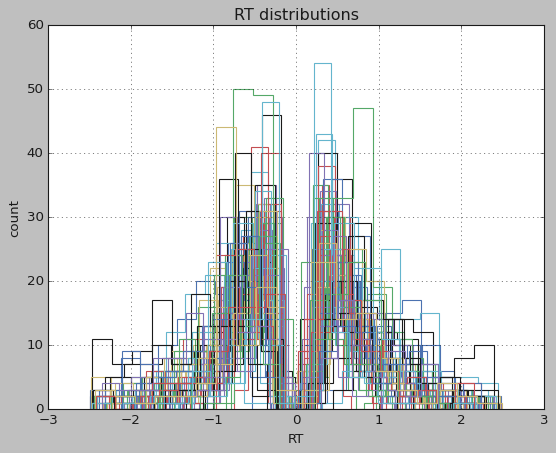

In [25]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


In [30]:
m1 = hddm.HDDM(
    data,
    depends_on={
        "a": "intertrial_delay",
        "v": "intertrial_delay",
        "t": "intertrial_delay"
    },
    p_outlier=0.05,
    informative=True,
)


No model attribute --> setting up standard HDDM
Set model to ddm


In [31]:
m1.find_starting_values()

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [32]:
m1.sample(1000, burn=500)

 [-----------------100%-----------------] 1001 of 1000 complete in 2681.6 sec

In [33]:
m1.print_stats()

                     mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(500)           1.437879  0.030679  1.377199  1.418903  1.439507  1.458242  1.495811  0.001912
a(750)           1.425222    0.0308  1.361066  1.405582   1.42724  1.447001  1.480544  0.001996
a(1000)          1.454021  0.030742  1.392339  1.435246  1.453056  1.475473  1.513739  0.001919
a(1250)           1.44187  0.029329  1.380575   1.42309  1.441775  1.462157  1.500577  0.001868
a(1500)          1.441962  0.028857   1.38658  1.421134  1.442851  1.461868  1.494986  0.001833
a(1750)          1.433923  0.030084  1.380474  1.412549  1.432998   1.45378   1.49398  0.001942
a(2000)          1.458058  0.029782  1.401382   1.43666  1.458295  1.479926  1.515118   0.00181
a(2250)          1.434735   0.03141  1.374644  1.413494  1.433263  1.454699  1.503639  0.001988
a(2500)          1.414759  0.033315  1.347334  1.392835  1.414068  1.437015  1.479776  0.002196
a_std            0.220881  0.010775  0.2

In [27]:
m.find_starting_values()

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [28]:
m.sample(2000, burn=500)

 [-----------------100%-----------------] 2001 of 2000 complete in 587.9 sec

In [29]:
m.print_stats()

               mean       std      2.5q       25q       50q       75q     97.5q    mc err
a          1.447393  0.025016  1.396106  1.431276  1.448191  1.464779  1.494994  0.000732
a_std      0.226097  0.019597  0.191151  0.212183  0.225081  0.238744  0.268979  0.000588
a_subj.1   1.697075  0.061038  1.588282  1.654383   1.69303  1.736852  1.830353   0.00191
a_subj.2   1.320621  0.056121  1.218933  1.281724  1.316326  1.357246  1.434244  0.001941
a_subj.3   1.367244  0.057383  1.263655  1.326822   1.36509  1.407033   1.48065  0.002382
a_subj.4   1.578697  0.058048   1.46856  1.540741  1.574866  1.616733   1.69502   0.00169
a_subj.5   1.157743  0.046111  1.074606  1.126433  1.156649  1.187887  1.256783  0.001831
a_subj.6   1.677021  0.063447  1.556331  1.632954  1.674731   1.72322   1.80483  0.002234
a_subj.7   1.645218  0.059595  1.532318  1.602912  1.642907  1.688586  1.761853  0.001948
a_subj.8   1.819409  0.066529   1.69653  1.772951  1.818292  1.864687  1.958021  0.002164
a_subj.9  

In [14]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod1 = hddm.Hrl(
    data,
    # bias=True,
    # dual=False,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    #informative=False,  # informative priors on ddm params
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [15]:
mod1.find_starting_values()

/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [16]:
mod1.sample(
    3000,
    burn=1000,
    dbname="ddm/ddm.db",
    db="pickle",
)

 [-----------------100%-----------------] 3001 of 3000 complete in 1038.8 sec

In [17]:
mod1.print_stats()

                     mean        std        2.5q         25q         50q         75q       97.5q    mc err
v               10.161469   2.723282    4.904567    8.338856   10.144104   11.937228   15.567607   0.06703
v_std           46.292885   1.295281   43.735836   45.429341   46.277022   47.176427   48.855305  0.052173
v_subj.1      -123.853859  23.072016 -173.632188  -137.79972 -122.181826 -107.757498  -84.001649  0.726093
v_subj.2       115.151022  27.498235   68.564691   95.356057  113.408843  133.129746  173.117892  0.883405
v_subj.3       188.424338  28.099559  136.842368  168.736352  187.086632  207.726094   247.35618  0.789724
v_subj.4       107.656343  29.365198   55.858014   86.690931  105.462816  126.679609  169.470533  0.927646
v_subj.5        135.11626   25.91617   89.866533  116.182003  133.004648  151.687219  188.105256  0.790694
v_subj.6        82.087339  22.435942   44.166623   66.190869   80.143555   96.064878  133.690997  1.001445
v_subj.7       181.509393  25.628439 

In [19]:
# get model traces 
grptrcs=mod1.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod1.get_traces() # traces of all stochastic nodes

In [20]:
# Export traces to .csv files (for later use in R)
# Saved in directory ddm, then moved by hand to saved_fits directory.
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


In [21]:
print("mod1 DIC: %f" % mod1.dic)

mod1 DIC: 94279.281894


In [22]:
import pymc as pm


Done saving traces (202206180603)

- If you estimate separate learning rates for positive and negative prediction errors (see here) then you get learning rate for negative prediction errors with `np.exp(alpha)/(1+np.exp(alpha))` and positive prediction errors with `np.exp(pos_alpha)/(1+np.exp(pos_alpha))`.
- The v-parameter in the output is the scaling factor that is multiplied by the difference in q-values, so it is not the actual drift rate (or rather, it is the equivalent drift rate when the difference in Q values is exactly 1).

In [23]:
# get the individual node
subj_data = mod1.get_subj_nodes()
# subj_data.head()


In [24]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n = mod1.nodes_db.node[
    ["alpha(AN.food)", "alpha(AN.neutral)", "alpha(HC.food)", "alpha(HC.neutral)"]
]

In [25]:
traces = mod1.get_traces()
traces.head()


a(AN.food)  a(AN.neutral)  a(BN.food)  a(BN.neutral)  a(HC.food)  \
0    1.350382       1.300891    1.481098       1.220845    1.334115   
1    1.332483       1.274069    1.444259       1.180849    1.328397   
2    1.347215       1.239252    1.387258       1.271979    1.324114   
3    1.359697       1.207024    1.421723       1.168296    1.313345   
4    1.367290       1.234811    1.381507       1.228082    1.324247   

   a(HC.neutral)  a(RI.food)  a(RI.neutral)     a_std  a_subj(AN.food).1  ...  \
0       1.253521    1.427091       1.221281  0.240849           1.159601  ...   
1       1.218986    1.327456       1.205451  0.223500           1.190090  ...   
2       1.229893    1.352425       1.206002  0.218843           1.292378  ...   
3       1.218228    1.429169       1.200326  0.218702           1.283111  ...   
4       1.240247    1.424351       1.270249  0.223789           1.370178  ...   

   pos_alpha_subj(RI.neutral).164  pos_alpha_subj(RI.neutral).167  \
0                        1.161749                        2.597826   
1                        5.772443                        2.908353   
2                        6.555269                        5.751279   
3                        6.830406                        1.635281   
4                        3.283669                        0.597550   

   pos_alpha_subj(RI.neutral).181  pos_alpha_subj(RI.neutral).198  \
0                        5.733157                        5.411948   
1                        4.954595                       10.008066   
2                        5.503370                        0.157628   
3                        2.743432                        3.243421   
4                        5.115952                        5.213870   

   pos_alpha_subj(RI.neutral).211  pos_alpha_subj(RI.neutral).216  \
0                        5.949756                        1.216308   
1                        3.910274                       -2.823466   
2                        5.659368                       -2.771982   
3                        5.930722                       -4.184022   
4                        7.165702                       -6.255864   

   pos_alpha_subj(RI.neutral).232  pos_alpha_subj(RI.neutral).265  \
0                        0.958331                       -0.756709   
1                       -0.033128                       -0.537404   
2                        0.033456                       -0.571748   
3                        0.092757                       -0.461110   
4                       -0.049706                       -0.638898   

   pos_alpha_subj(RI.neutral).272  pos_alpha_subj(RI.neutral).278  
0                        3.043476                        0.224358  
1                        1.768558                        0.108446  
2                        1.582180                       -0.548496  
3                        8.973374                       -1.151233  
4                        1.846401                       -0.248420  

[5 rows x 2755 columns]

In [26]:
# Saved and then moved by hand to saved_fits directory.
traces.to_csv("ddm/traces.csv")

<AxesSubplot: xlabel='pos_alpha(AN.neutral)', ylabel='Density'>

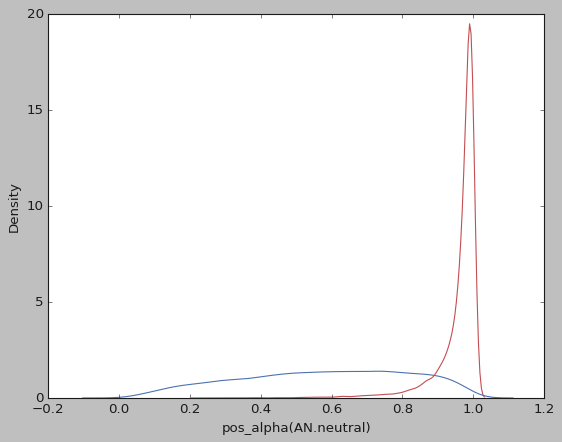

In [27]:
pos_alpha_n = np.exp(traces["pos_alpha(AN.neutral)"]) / (1 + np.exp(traces["pos_alpha(AN.neutral)"]))
pos_alpha_f = np.exp(traces["pos_alpha(AN.food)"]) / (1 + np.exp(traces["pos_alpha(AN.food)"]))


sns.kdeplot(
    pos_alpha_n, color="r", label="neg_alpha: " + str(np.round(np.mean(pos_alpha_n), 3))
)
sns.kdeplot(
    pos_alpha_f, color="b", label="pos_alpha: " + str(np.round(np.mean(pos_alpha_f), 3))
)

In [ ]:
# alpha_an_f.trace()


In [28]:
def inv_logits(x):
    return np.exp(x) / (1 + np.exp(x))

In [29]:
traces["score_diff"] = traces["pos_alpha(AN.neutral)"] - traces["pos_alpha(AN.food)"] 
quantiles = traces['score_diff'].quantile([0.025, 0.50, 0.975])
quantiles

0.025   -0.366033
0.500    3.624844
0.975    7.657586
Name: score_diff, dtype: float64

In [30]:
inv_logits(quantiles)

0.025    0.409500
0.500    0.974039
0.975    0.999528
Name: score_diff, dtype: float64

In [31]:
traces["score_diff"] = traces["alpha(AN.food)"] - traces["alpha(AN.neutral)"] 
quantiles = traces['score_diff'].quantile([0.025, 0.50, 0.975])
quantiles

0.025   -2.899869
0.500    0.814845
0.975    4.624808
Name: score_diff, dtype: float64

In [32]:
# traces["score_diff"] = traces["a(AN.food)"] - traces["a(AN.neutral)"]
# traces["score_diff"] = traces["a(BN.food)"] - traces["a(BN.neutral)"]
# traces["score_diff"] = traces["a(HC.food)"] - traces["a(HC.neutral)"]
traces["score_diff"] = traces["a(RI.food)"] - traces["a(RI.neutral)"]

The following code creates a figure of the posterior density plot of the difference between the parameters estimated in two conditions.


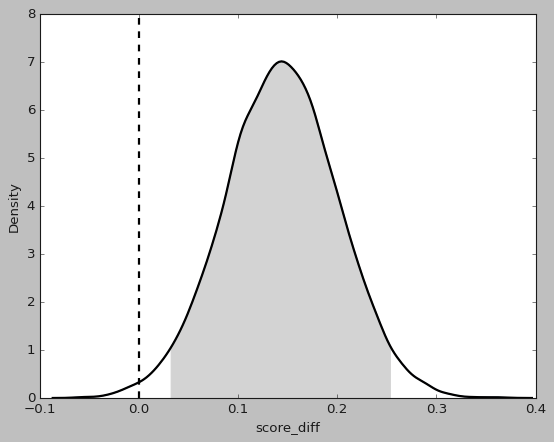

In [33]:
quantiles = traces['score_diff'].quantile([0.025, 0.975])

# Define delta lower and upper limits
low, high = quantiles[0.025], quantiles[0.975]

sns_plot = sns.kdeplot(data=traces, x="score_diff")

line = sns_plot.lines[0]
x, y = line.get_data()

plt.plot(x, y, color='black', lw=2)

idx_delta = np.logical_and(x >= low, x <= high)

plt.fill_between(x, y, where=idx_delta, color='lightgray')

plt.axvline(0, color='black', linestyle='--', linewidth=2)

sns_plot.figure.savefig("output.pdf")


In [34]:
# get model traces
grptrcs = mod1.get_group_traces()  # traces of all stochastic group nodes
alltrcs = mod1.get_traces()  # traces of all stochastic nodes


In [35]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


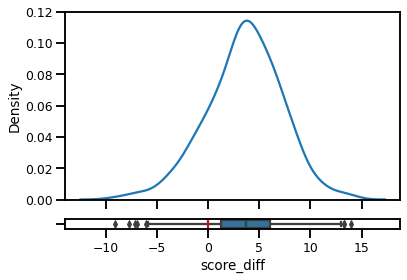

In [114]:
# # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
# f, (ax_kdeplot, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.95, .05)})

# # assigning a graph to each ax

# sns.kdeplot(data=traces, x="score_diff", ax=ax_kdeplot)
# plt.axvline(0, color='r')

# sns.boxplot(data=traces, x="score_diff", ax=ax_box)

# # Remove x axis name for the boxplot
# # ax_box.set(xlabel='')
# plt.show()

# # plt.savefig('plot_score_diff.pdf')


In [36]:
alpha_an_f,  alpha_an_n, alpha_bn_f,  alpha_bn_n, alpha_hc_f,  alpha_hc_n, alpha_ri_f,  alpha_ri_n = mod1.nodes_db.node[[
    'alpha(AN.food)',   'alpha(AN.neutral)',
    'alpha(BN.food)',   'alpha(BN.neutral)',
    'alpha(HC.food)',   'alpha(HC.neutral)',
    'alpha(RI.food)',   'alpha(RI.neutral)',
]]


In [37]:
pos_alpha_an_f,  pos_alpha_an_n, pos_alpha_bn_f,  pos_alpha_bn_n, pos_alpha_hc_f,  pos_alpha_hc_n, pos_alpha_ri_f,  pos_alpha_ri_n = mod1.nodes_db.node[[
    'pos_alpha(AN.food)',   'pos_alpha(AN.neutral)',
    'pos_alpha(BN.food)',   'pos_alpha(BN.neutral)',
    'pos_alpha(HC.food)',   'pos_alpha(HC.neutral)',
    'pos_alpha(RI.food)',   'pos_alpha(RI.neutral)',
]]


In [48]:
mod1.plot_posterior_predictive()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Alpha


Text(0.5, 1.0, 'Posterior of negative alpha group means')

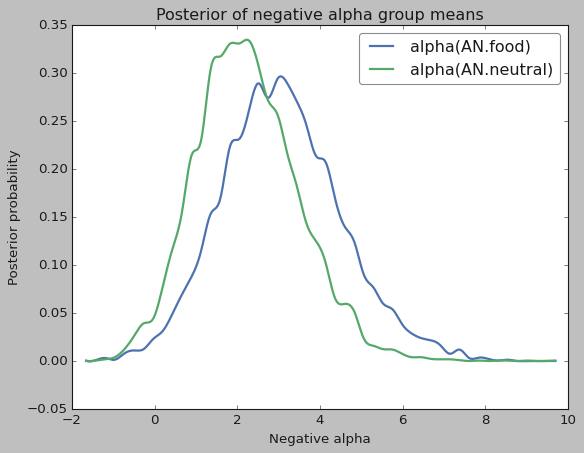

In [38]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_an_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


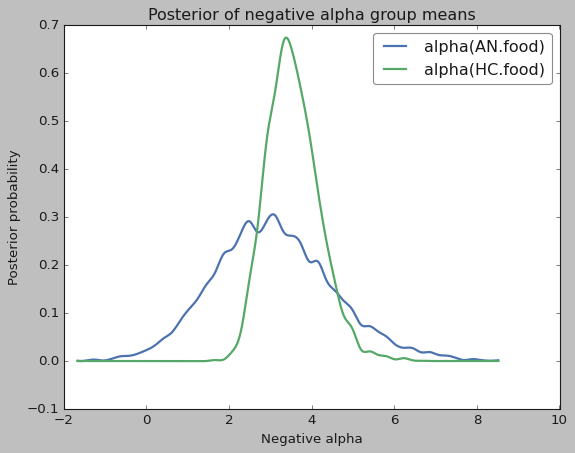

In [39]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_hc_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')
plt.savefig('negative_alpha_group_means.pdf', pad_inches=4.5)


Text(0.5, 1.0, 'Posterior of negative alpha group means')

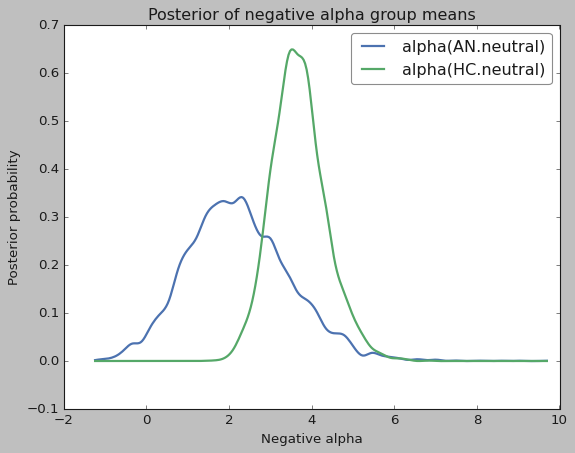

In [40]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

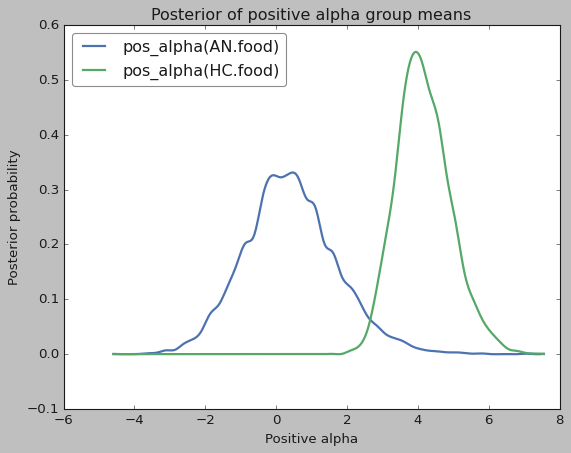

In [41]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_f, pos_alpha_hc_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


Text(0.5, 1.0, 'Posterior of positive alpha group means')

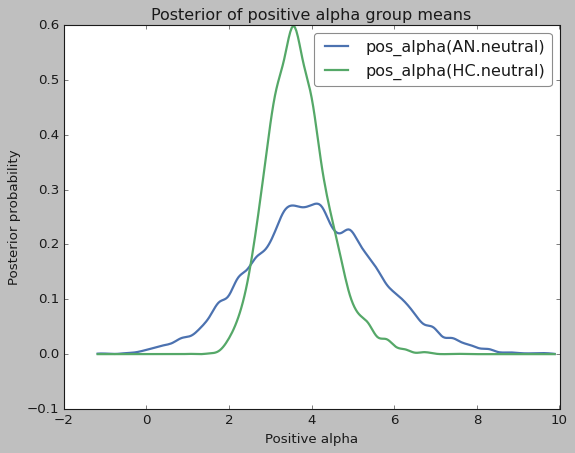

In [42]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')


In [43]:
print(
    "P(neg-alpha AN food > neg-alpha HC food) = ",
    (alpha_an_f.trace() > alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha AN neutral > neg-alpha HC neutral) = ",
    (alpha_an_n.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food > pos-alpha HC food) = ",
    (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha AN neutral > pos-alpha HC neutral) = ",
    (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha AN food > neg-alpha HC food) =  0.3722
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.145
P(pos-alpha AN food > pos-alpha HC food) =  0.0092
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.5979


In [44]:
print("P(neg-alpha BN food < neg-alpha HC food) = ",
      (alpha_bn_f.trace() < alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral < neg-alpha HC neutral) = ",
      (alpha_bn_n.trace() < alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food < pos-alpha HC food) = ",
      (pos_alpha_bn_f.trace() < pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral < pos-alpha HC neutral) = ",
      (pos_alpha_bn_n.trace() < pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food < neg-alpha HC food) =  0.7985
P(neg-alpha BN neutral < neg-alpha HC neutral) =  0.4756
P(pos-alpha BN food < pos-alpha HC food) =  0.9178
P(pos-alpha BN neutral < pos-alpha HC neutral) =  0.4643


In [45]:
print(
    "P(neg-alpha HC food > neg-alpha HC neutral) = ",
    (alpha_hc_f.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(neg-alpha AN food > neg-alpha AN neutral) = ",
    (alpha_an_f.trace() > alpha_an_n.trace()).mean(),
)
print(
    "P(neg-alpha BN food > neg-alpha BN neutral) = ",
    (alpha_bn_f.trace() > alpha_bn_n.trace()).mean(),
)
print(
    "P(neg-alpha RI food > neg-alpha RI neutral) = ",
    (alpha_ri_f.trace() > alpha_ri_n.trace()).mean(),
)
print(
    "P(pos-alpha HC food > pos-alpha HC neutral) = ",
    (pos_alpha_hc_f.trace() > pos_alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food > pos-alpha AN neutral) = ",
    (pos_alpha_an_f.trace() > pos_alpha_an_n.trace()).mean(),
)
print(
    "P(pos-alpha BN food > pos-alpha BN neutral) = ",
    (pos_alpha_bn_f.trace() > pos_alpha_bn_n.trace()).mean(),
)
print(
    "P(pos-alpha RI food > pos-alpha RI neutral) = ",
    (pos_alpha_ri_f.trace() > pos_alpha_ri_n.trace()).mean(),
)

P(neg-alpha HC food > neg-alpha HC neutral) =  0.4148
P(neg-alpha AN food > neg-alpha AN neutral) =  0.6681
P(neg-alpha BN food > neg-alpha BN neutral) =  0.2237
P(neg-alpha RI food > neg-alpha RI neutral) =  0.6927
P(pos-alpha HC food > pos-alpha HC neutral) =  0.6764
P(pos-alpha AN food > pos-alpha AN neutral) =  0.0372
P(pos-alpha BN food > pos-alpha BN neutral) =  0.1755
P(pos-alpha RI food > pos-alpha RI neutral) =  0.8608


In [46]:
print(
    "P(neg-alpha AN food > neg-alpha HC food) = ",
    (alpha_an_f.trace() > alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha AN neutral > neg-alpha HC neutral) = ",
    (alpha_an_n.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha AN food > pos-alpha HC food) = ",
    (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha AN neutral > pos-alpha HC neutral) = ",
    (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha AN food > neg-alpha HC food) =  0.3722
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.145
P(pos-alpha AN food > pos-alpha HC food) =  0.0092
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.5979


In [47]:
print(
    "P(neg-alpha BN food > neg-alpha HC food) = ",
    (alpha_bn_f.trace() > alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha BN neutral > neg-alpha HC neutral) = ",
    (alpha_bn_n.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha BN food > pos-alpha HC food) = ",
    (pos_alpha_bn_f.trace() > pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha BN neutral > pos-alpha HC neutral) = ",
    (pos_alpha_bn_n.trace() > pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha BN food > neg-alpha HC food) =  0.2015
P(neg-alpha BN neutral > neg-alpha HC neutral) =  0.5244
P(pos-alpha BN food > pos-alpha HC food) =  0.0822
P(pos-alpha BN neutral > pos-alpha HC neutral) =  0.5357


In [48]:
print(
    "P(pos-alpha BN food < pos-alpha AN food) = ",
    (pos_alpha_bn_f.trace() < pos_alpha_an_f.trace()).mean(),
)
print(
    "P(pos-alpha BN neutral < pos-alpha AN neutral) = ",
    (pos_alpha_bn_n.trace() < pos_alpha_an_n.trace()).mean(),
)
print(
    "P(neg-alpha BN food < neg-alpha AN food) = ",
    (alpha_bn_f.trace() < alpha_an_f.trace()).mean(),
)
print(
    "P(neg-alpha BN neutral < neg-alpha AN neutral) = ",
    (alpha_bn_n.trace() < alpha_an_n.trace()).mean(),
)

P(pos-alpha BN food < pos-alpha AN food) =  0.333
P(pos-alpha BN neutral < pos-alpha AN neutral) =  0.5293
P(neg-alpha BN food < neg-alpha AN food) =  0.6858
P(neg-alpha BN neutral < neg-alpha AN neutral) =  0.2248


In [49]:
print(
    "P(neg-alpha RI food > neg-alpha HC food) = ",
    (alpha_ri_f.trace() > alpha_hc_f.trace()).mean(),
)
print(
    "P(neg-alpha RI neutral > neg-alpha HC neutral) = ",
    (alpha_ri_n.trace() > alpha_hc_n.trace()).mean(),
)
print(
    "P(pos-alpha RI food > pos-alpha HC food) = ",
    (pos_alpha_ri_f.trace() > pos_alpha_hc_f.trace()).mean(),
)
print(
    "P(pos-alpha RI neutral > pos-alpha HC neutral) = ",
    (pos_alpha_ri_n.trace() > pos_alpha_hc_n.trace()).mean(),
)

P(neg-alpha RI food > neg-alpha HC food) =  0.245
P(neg-alpha RI neutral > neg-alpha HC neutral) =  0.0874
P(pos-alpha RI food > pos-alpha HC food) =  0.4103
P(pos-alpha RI neutral > pos-alpha HC neutral) =  0.0974


In [ ]:
# the plot shows that the model was able to recover the different decision threshold across groups.
a_group1, a_group2 = mod1.nodes_db.node[["a(group1)", "a(group2)"]]
hddm.analyze.plot_posterior_nodes([a_group1, a_group2])
plt.xlabel("decision threshold")
plt.ylabel("Posterior probability")
plt.xlim(0.7, 2.3)
plt.title("Posterior of decision threshold group means")

Text(0.5, 1.0, 'AN: Posterior of positive alpha condition means')

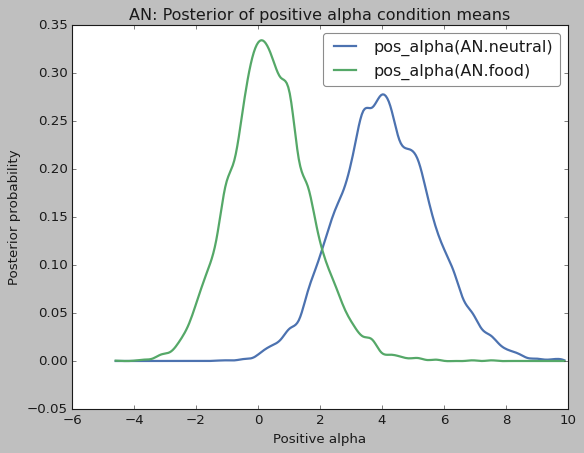

In [51]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_an_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('AN: Posterior of positive alpha condition means')

Text(0.5, 1.0, 'AN: Posterior of negative alpha condition means')

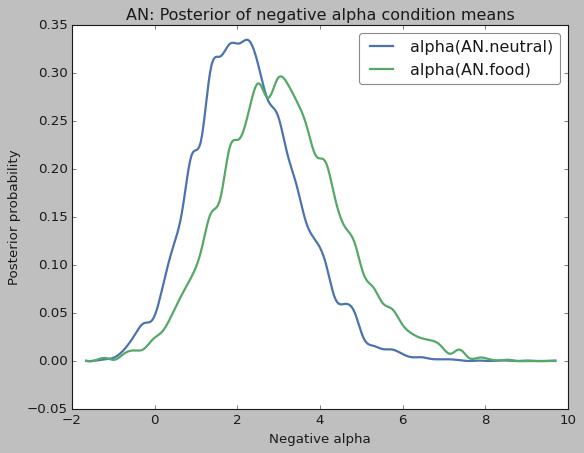

In [52]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_an_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('AN: Posterior of negative alpha condition means')

# Drift rate


In [53]:
v_an_f,  v_an_n, v_bn_f,  v_bn_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)',
    'v(BN.food)',   'v(BN.neutral)',
    'v(HC.food)',   'v(HC.neutral)',
    'v(RI.food)',   'v(RI.neutral)',
]]


In [54]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ",
      (v_an_n.trace() > v_hc_n.trace()).mean())


P(v AN food > v HC food) =  0.0679
P(v AN neutral > v HC neutral) =  0.2096


In [55]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ",
      (v_bn_n.trace() > v_hc_n.trace()).mean())


P(v BN food > v HC food) =  0.4423
P(v BN neutral > v HC neutral) =  0.5551


In [56]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ",
      (v_ri_n.trace() > v_hc_n.trace()).mean())


P(v RI food > v HC food) =  0.3637
P(v RI neutral > v HC neutral) =  0.9827


In [57]:
print("P(v AN food > v AN neutral) = ", (v_an_f.trace() > v_an_n.trace()).mean())
print("P(v BN food > v BN neutral) = ", (v_bn_f.trace() > v_bn_n.trace()).mean())
print("P(v HC food > v HC neutral) = ", (v_hc_f.trace() > v_hc_n.trace()).mean())
print("P(v RI food > v RI neutral) = ", (v_ri_f.trace() > v_ri_n.trace()).mean())

P(v AN food > v AN neutral) =  0.1714
P(v BN food > v BN neutral) =  0.3176
P(v HC food > v HC neutral) =  0.1456
P(v RI food > v RI neutral) =  0.0085


In [58]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ", (v_an_n.trace() > v_hc_n.trace()).mean())
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ", (v_bn_n.trace() > v_hc_n.trace()).mean())
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ", (v_ri_n.trace() > v_hc_n.trace()).mean())
print("P(v AN food > v BN food) = ", (v_an_f.trace() > v_bn_f.trace()).mean())
print("P(v AN neutral > v BN neutral) = ", (v_an_n.trace() > v_bn_n.trace()).mean())

P(v AN food > v HC food) =  0.0679
P(v AN neutral > v HC neutral) =  0.2096
P(v BN food > v HC food) =  0.4423
P(v BN neutral > v HC neutral) =  0.5551
P(v RI food > v HC food) =  0.3637
P(v RI neutral > v HC neutral) =  0.9827
P(v AN food > v BN food) =  0.2429
P(v AN neutral > v BN neutral) =  0.2806


# Decision threshold


In [59]:
a_an_f, a_an_n, a_bn_f, a_bn_n, a_hc_f, a_hc_n, a_ri_f, a_ri_n = mod1.nodes_db.node[
    [
        "a(AN.food)",
        "a(AN.neutral)",
        "a(BN.food)",
        "a(BN.neutral)",
        "a(HC.food)",
        "a(HC.neutral)",
        "a(RI.food)",
        "a(RI.neutral)",
    ]
]

In [60]:
print("P(a AN food < a AN neutral) = ", (a_an_f.trace() < a_an_n.trace()).mean())
print("P(a BN food < a BN neutral) = ", (a_bn_f.trace() < a_bn_n.trace()).mean())
print("P(a HC food < a HC neutral) = ", (a_hc_f.trace() < a_hc_n.trace()).mean())
print("P(a RI food < a RI neutral) = ", (a_ri_f.trace() < a_ri_n.trace()).mean())

P(a AN food < a AN neutral) =  0.0079
P(a BN food < a BN neutral) =  0.0062
P(a HC food < a HC neutral) =  0.0003
P(a RI food < a RI neutral) =  0.0066


In [61]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ", (a_an_n.trace() < a_hc_n.trace()).mean())


P(a AN food < a HC food) =  0.1086
P(a AN neutral < a HC neutral) =  0.4779


In [62]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ", (a_bn_n.trace() < a_hc_n.trace()).mean())


P(a BN food < a HC food) =  0.0545
P(a BN neutral < a HC neutral) =  0.7252


In [63]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ", (a_ri_n.trace() < a_hc_n.trace()).mean())

P(a RI food < a HC food) =  0.0821
P(a RI neutral < a HC neutral) =  0.5311


In [64]:
print("P(a AN food < a BN food) = ", (a_an_f.trace() < a_bn_f.trace()).mean())
print("P(a AN neutral < a BN neutral) = ", (a_an_n.trace() < a_bn_n.trace()).mean())

P(a AN food < a BN food) =  0.7847
P(a AN neutral < a BN neutral) =  0.2811


# Non decision time


In [65]:
(t_an_f, t_an_n, t_bn_f, t_bn_n, t_hc_f, t_hc_n, t_ri_f, t_ri_n,) = mod1.nodes_db.node[
    [
        "t(AN.food)",
        "t(AN.neutral)",
        "t(BN.food)",
        "t(BN.neutral)",
        "t(HC.food)",
        "t(HC.neutral)",
        "t(RI.food)",
        "t(RI.neutral)",
    ]
]

In [66]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ", (t_an_n.trace() < t_hc_n.trace()).mean())

P(t AN food < t HC food) =  0.3992
P(t AN neutral < t HC neutral) =  0.3186


In [67]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ", (t_bn_n.trace() < t_hc_n.trace()).mean())

P(t BN food < t HC food) =  0.6992
P(t BN neutral < t HC neutral) =  0.4281


In [68]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ", (t_ri_n.trace() < t_hc_n.trace()).mean())

P(t RI food < t HC food) =  0.25
P(t RI neutral < t HC neutral) =  0.3407


In [69]:
print("P(t AN food < t AN neutral) = ", (t_an_f.trace() < t_an_n.trace()).mean())
print("P(t BN food < t BN neutral) = ", (t_bn_f.trace() < t_bn_n.trace()).mean())
print("P(t HC food < t HC neutral) = ", (t_hc_f.trace() < t_hc_n.trace()).mean())
print("P(t RI food < t RI neutral) = ", (t_ri_f.trace() < t_ri_n.trace()).mean())

P(t AN food < t AN neutral) =  0.7617
P(t BN food < t BN neutral) =  0.7926
P(t HC food < t HC neutral) =  0.9159
P(t RI food < t RI neutral) =  0.6352


In [70]:
print("P(t AN food < t BN food) = ", (t_an_f.trace() < t_bn_f.trace()).mean())
print("P(t AN neutral < t BN neutral) = ", (t_an_n.trace() < t_bn_n.trace()).mean())

P(t AN food < t BN food) =  0.2729
P(t AN neutral < t BN neutral) =  0.464


# Print fitted parameters and other model statistics


In [71]:
mod1.print_stats()


                                    mean       std       2.5q       25q       50q       75q      97.5q    mc err
a(AN.food)                      1.370681  0.038634    1.29408  1.344247  1.371201  1.396557   1.446292  0.000466
a(AN.neutral)                   1.239559   0.03855   1.162007  1.214531  1.239432  1.265099    1.31546  0.000423
a(BN.food)                      1.431753  0.066875   1.299918  1.386827  1.433425  1.476763   1.558837  0.000706
a(BN.neutral)                    1.19349  0.071071    1.05233  1.145706  1.194375  1.241753   1.330027   0.00079
a(HC.food)                      1.319165  0.016055   1.287621    1.3084  1.319229  1.329912   1.350713   0.00019
a(HC.neutral)                   1.237496  0.016682   1.204958  1.226031   1.23743   1.24881   1.270009  0.000197
a(RI.food)                      1.377577  0.038598   1.300846  1.351112  1.378037  1.403642   1.453514  0.000432
a(RI.neutral)                   1.233735  0.041804   1.151644  1.205807  1.233947  1.262144   1.

## Checking results


Plotting a(AN.food)
Plotting a(AN.neutral)
Plotting a(BN.food)
Plotting a(BN.neutral)
Plotting a(HC.food)
Plotting a(HC.neutral)
Plotting a(RI.food)
Plotting a(RI.neutral)
Plotting a_std
Plotting v(AN.food)
Plotting v(AN.neutral)
Plotting v(BN.food)
Plotting v(BN.neutral)
Plotting v(HC.food)
Plotting v(HC.neutral)
Plotting v(RI.food)
Plotting v(RI.neutral)
Plotting v_std
Plotting t(AN.food)
Plotting t(AN.neutral)
Plotting t(BN.food)


/Users/corrado/opt/anaconda3/envs/hddm_env/lib/python3.9/site-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(10, 6))


Plotting t(BN.neutral)
Plotting t(HC.food)
Plotting t(HC.neutral)
Plotting t(RI.food)
Plotting t(RI.neutral)
Plotting t_std
Plotting alpha(AN.food)
Plotting alpha(AN.neutral)
Plotting alpha(BN.food)
Plotting alpha(BN.neutral)
Plotting alpha(HC.food)
Plotting alpha(HC.neutral)
Plotting alpha(RI.food)
Plotting alpha(RI.neutral)
Plotting alpha_std
Plotting pos_alpha(AN.food)
Plotting pos_alpha(AN.neutral)
Plotting pos_alpha(BN.food)
Plotting pos_alpha(BN.neutral)
Plotting pos_alpha(HC.food)
Plotting pos_alpha(HC.neutral)
Plotting pos_alpha(RI.food)
Plotting pos_alpha(RI.neutral)
Plotting pos_alpha_std


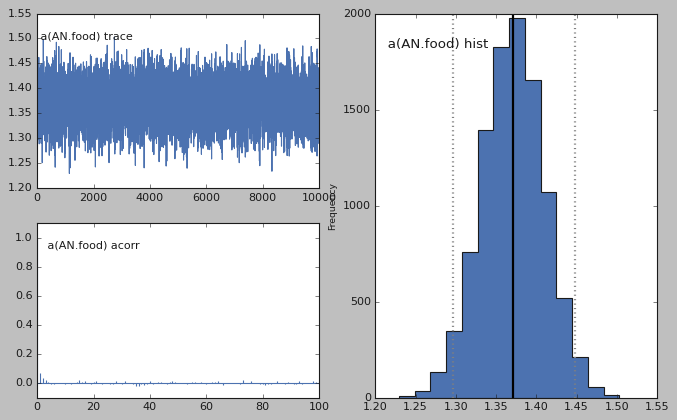

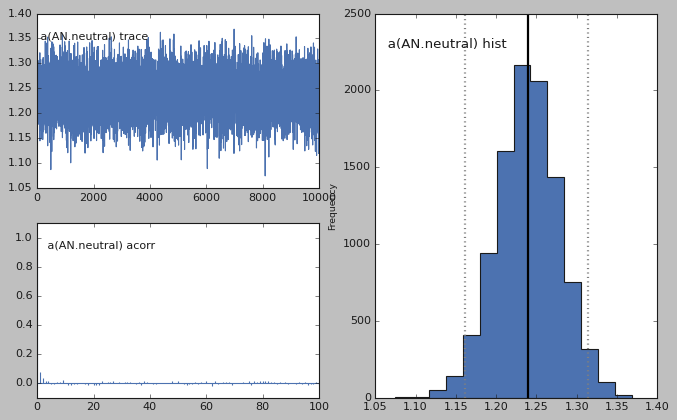

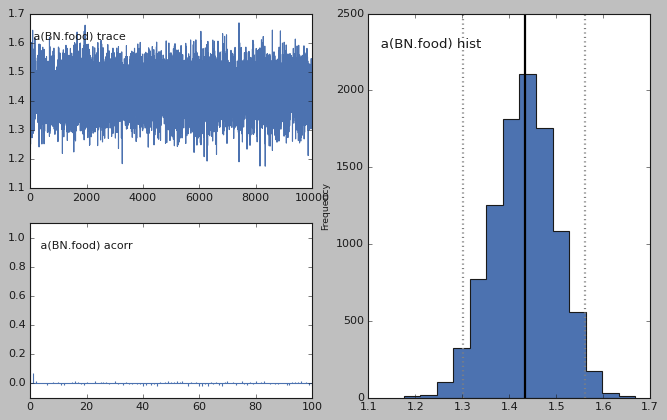

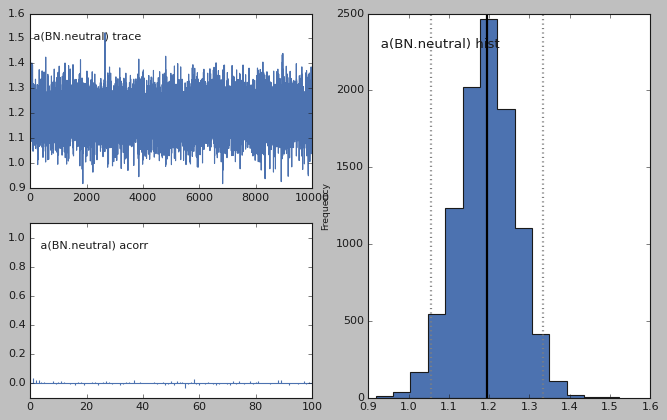

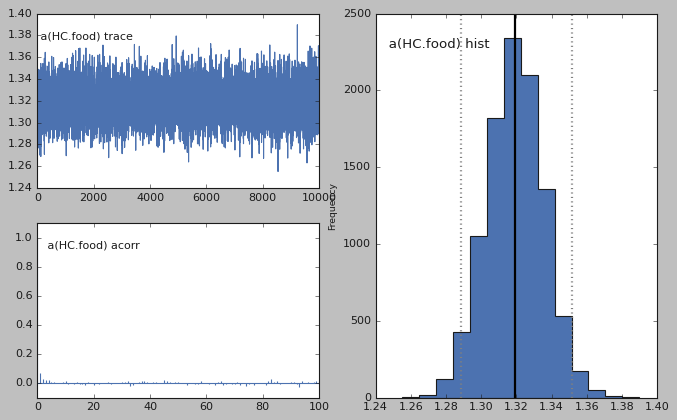

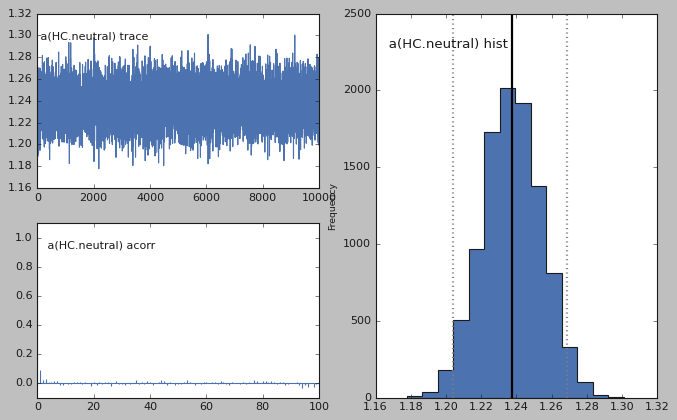

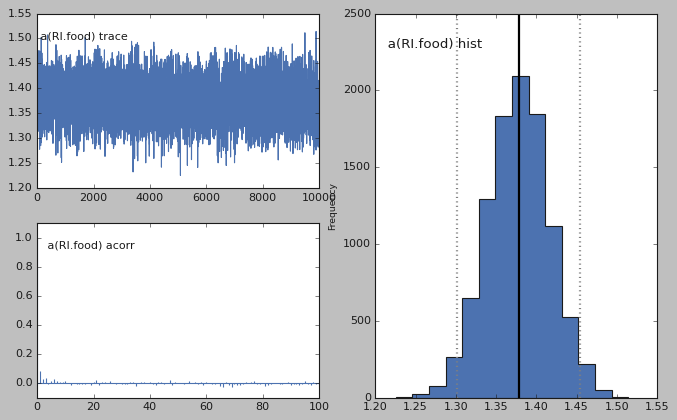

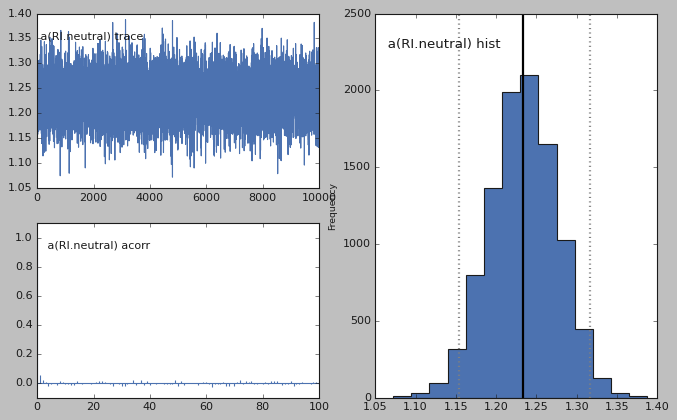

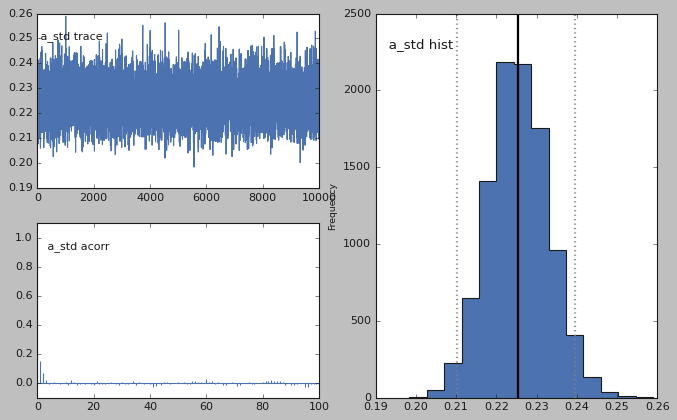

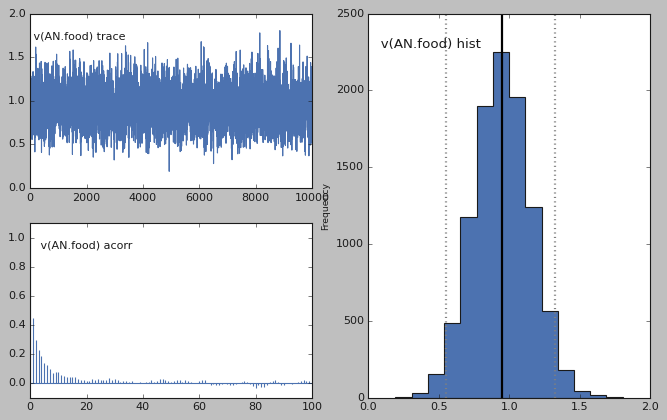

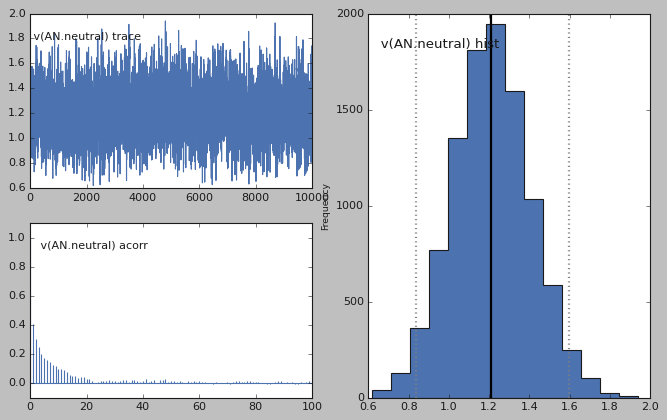

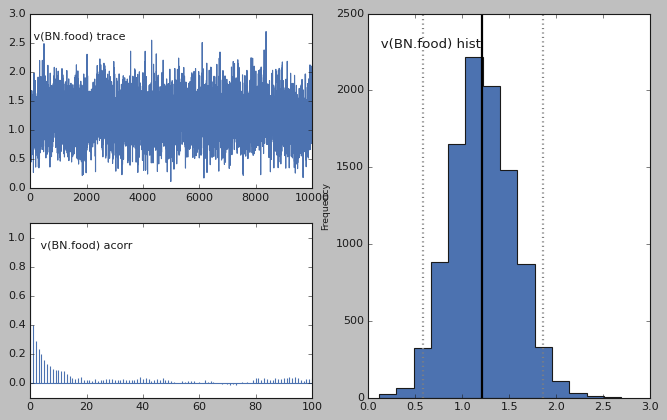

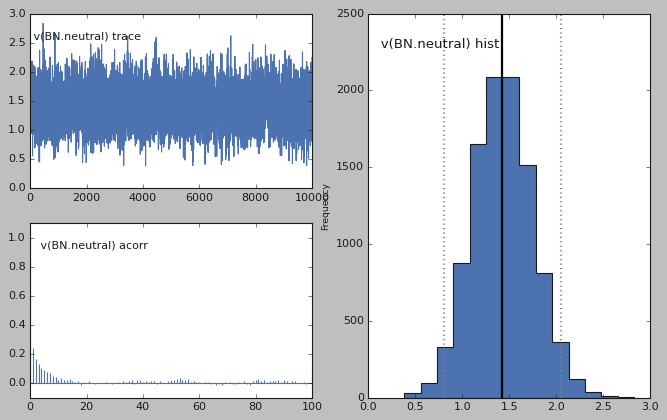

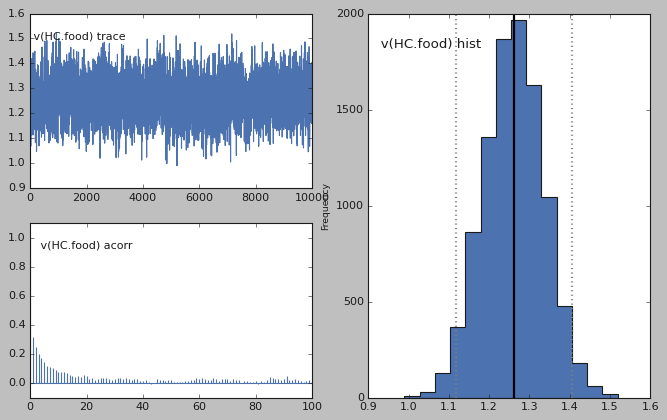

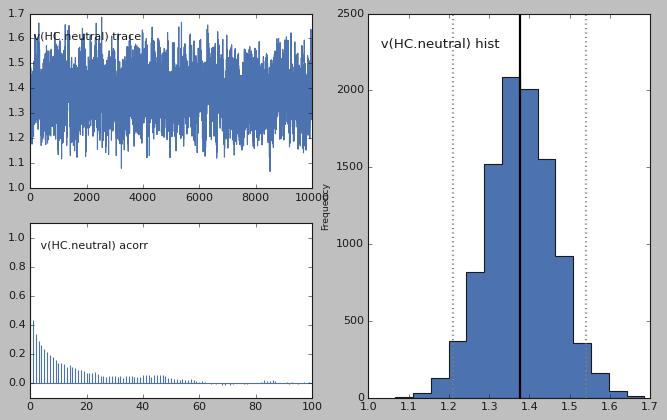

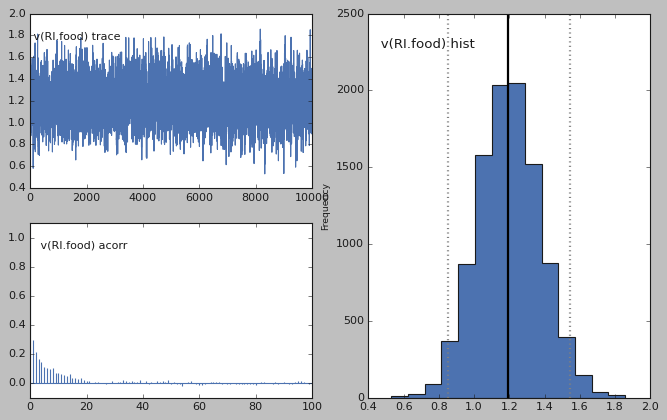

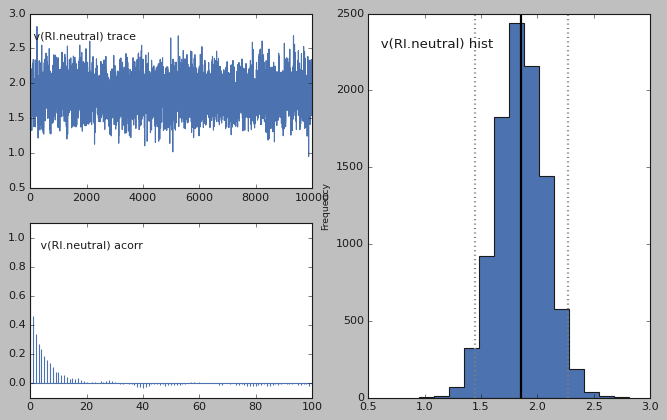

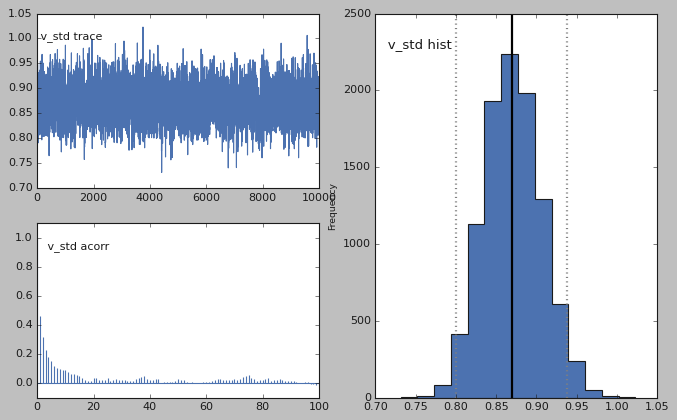

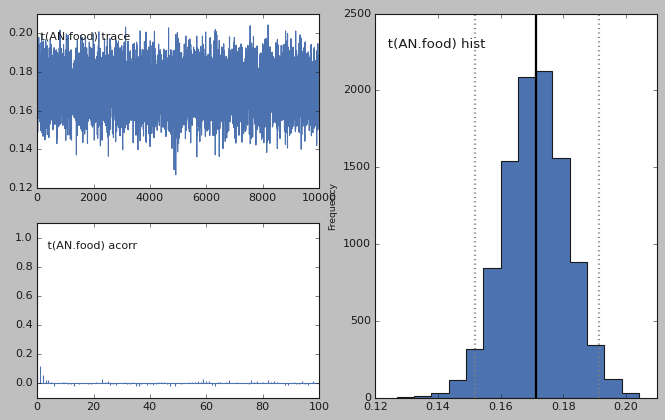

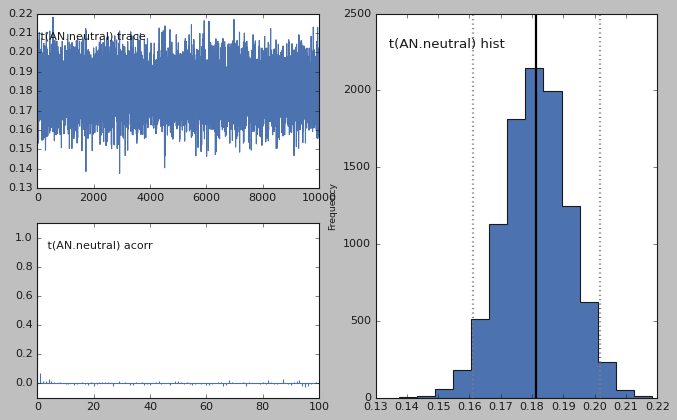

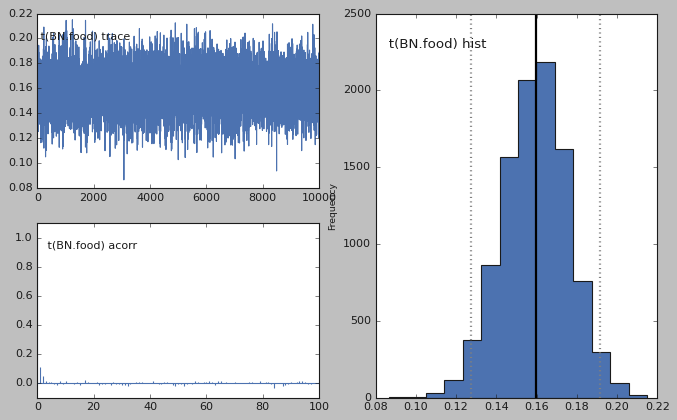

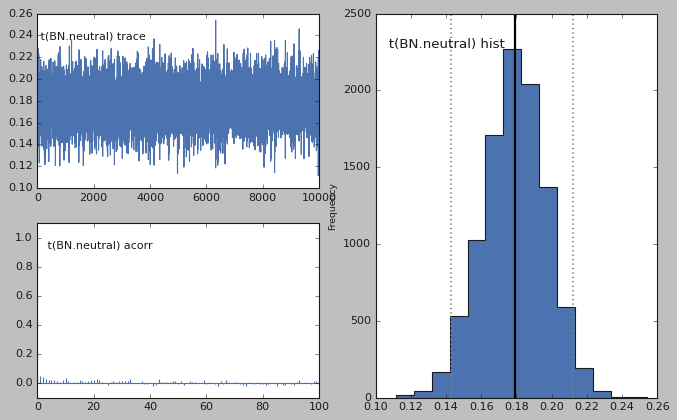

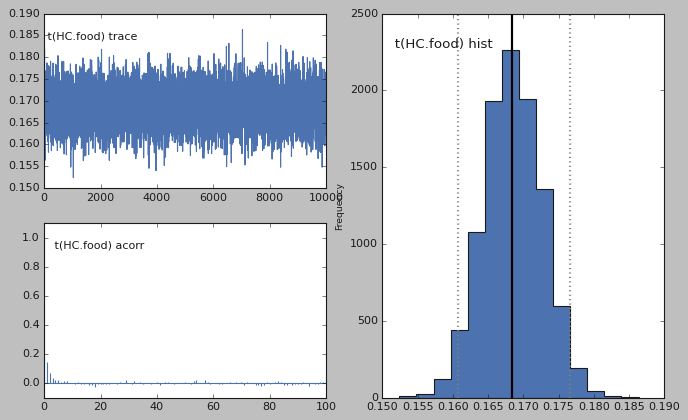

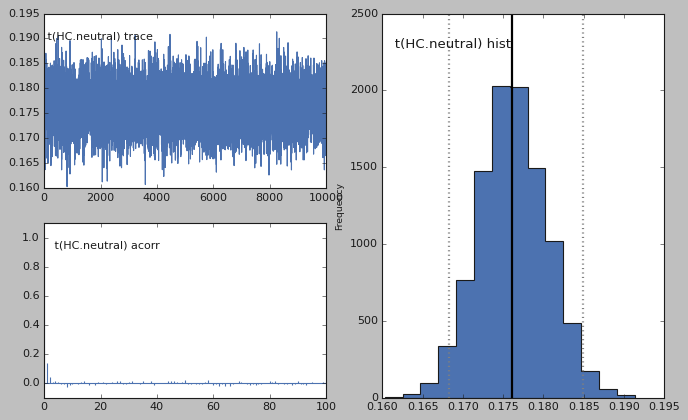

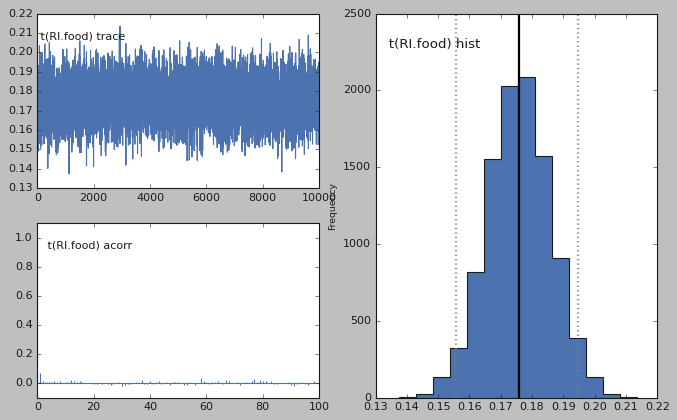

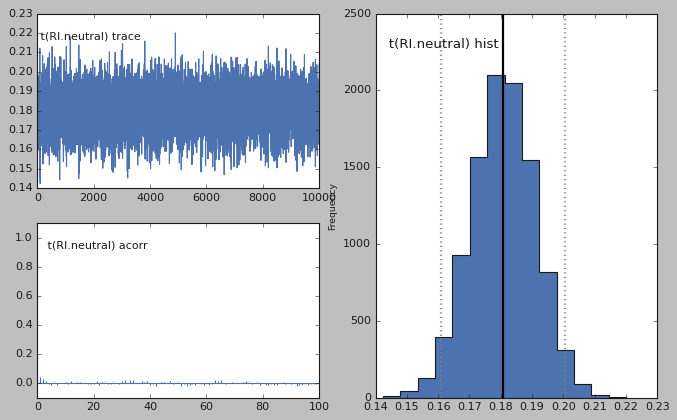

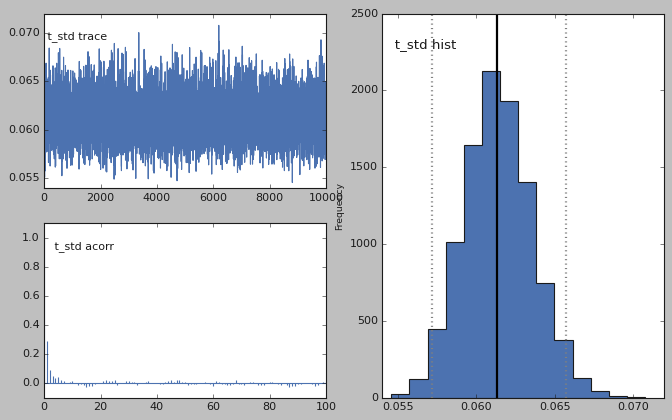

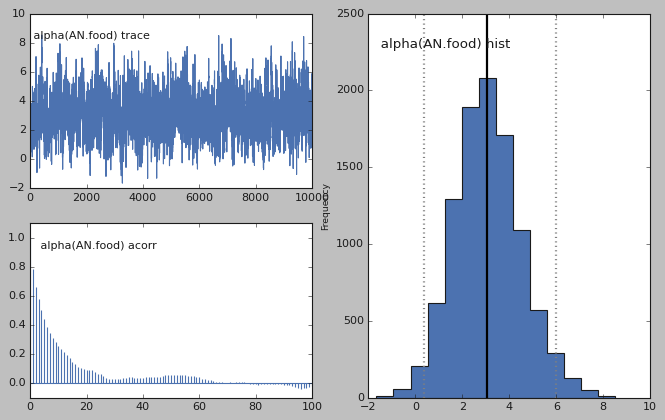

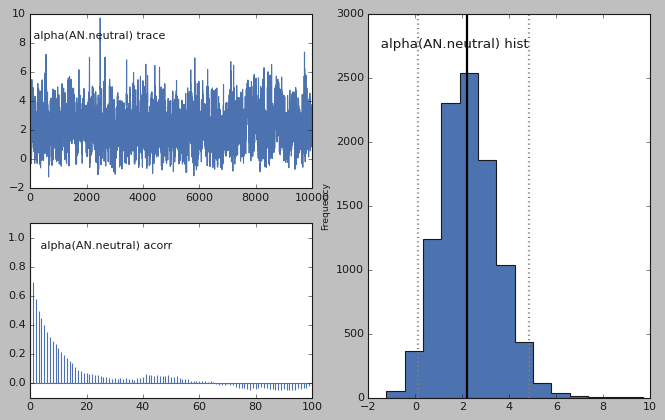

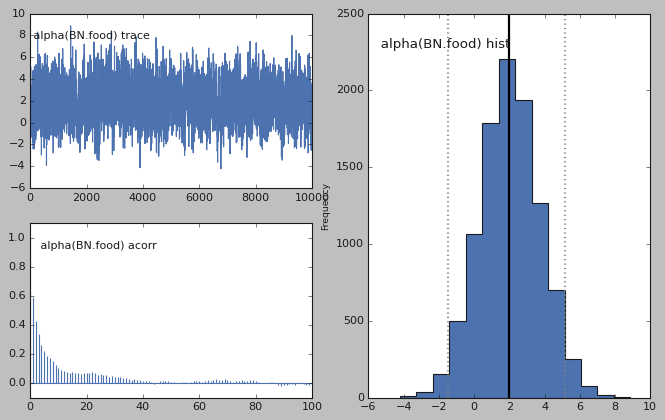

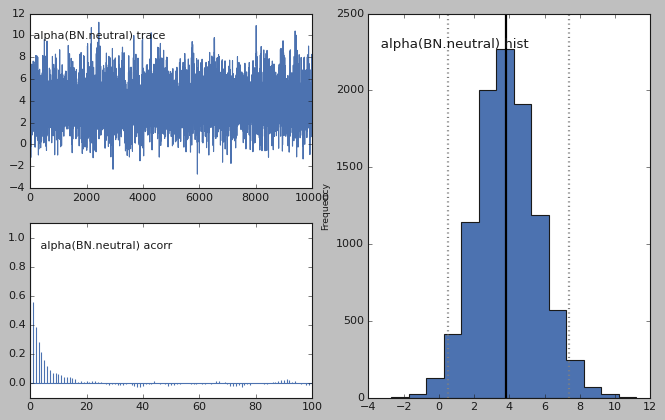

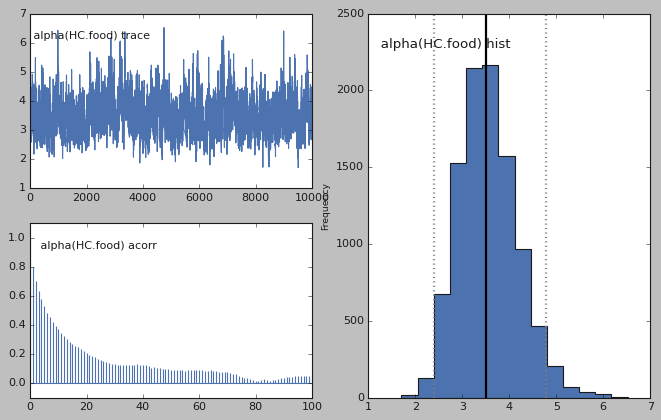

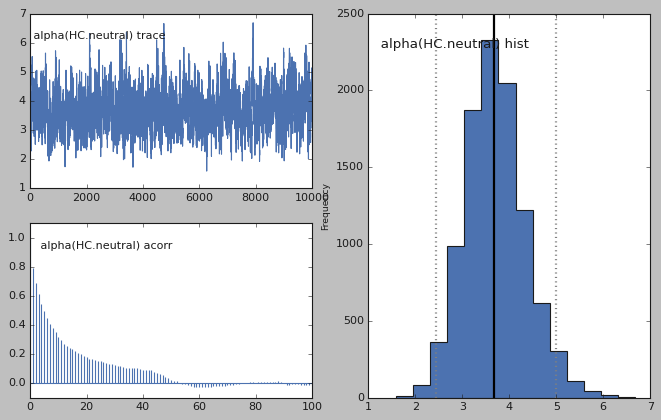

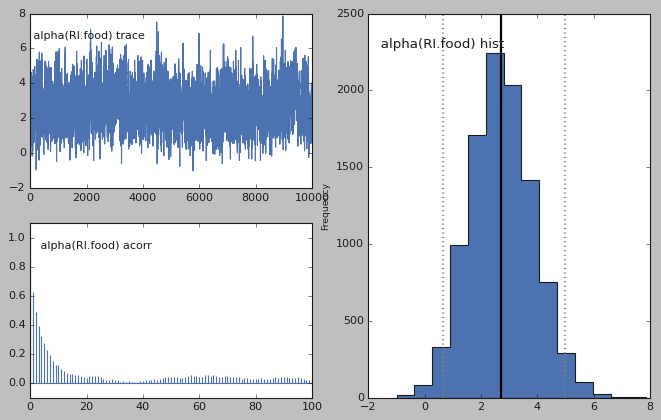

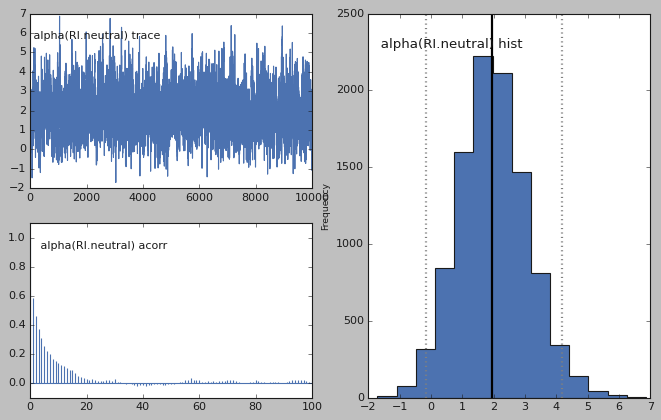

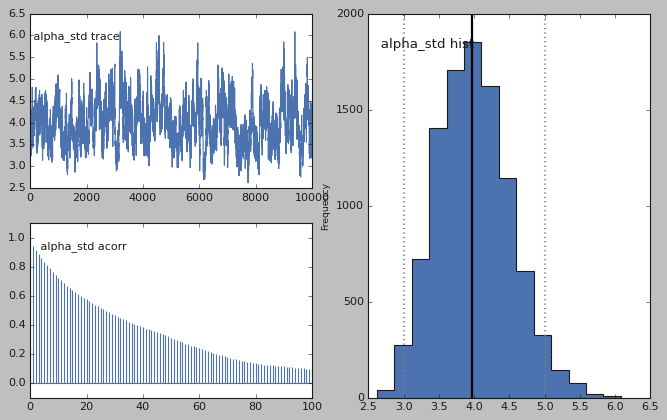

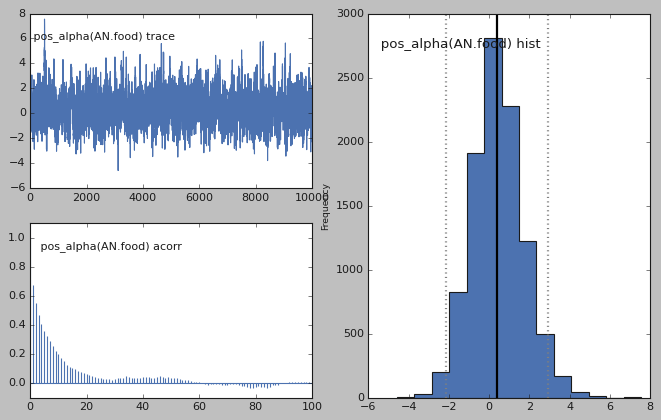

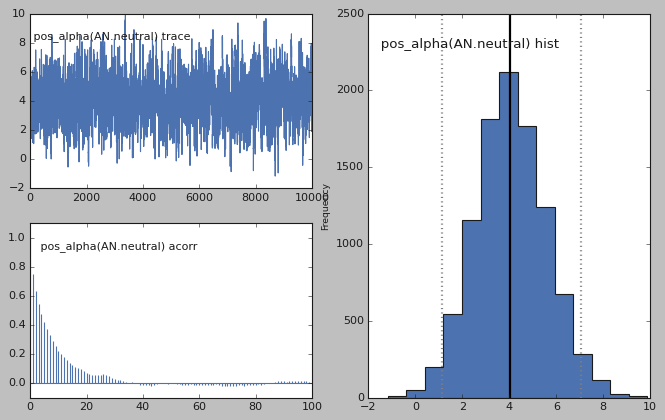

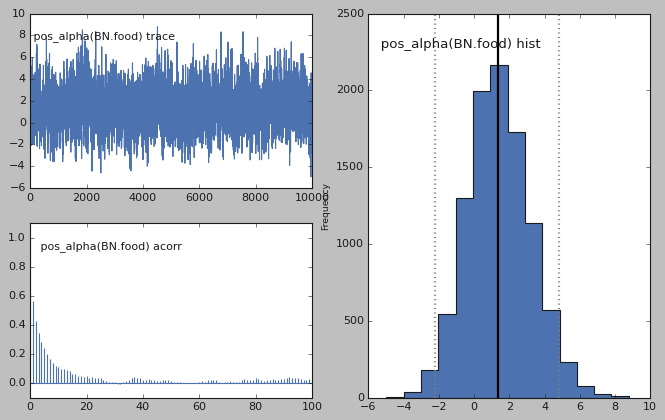

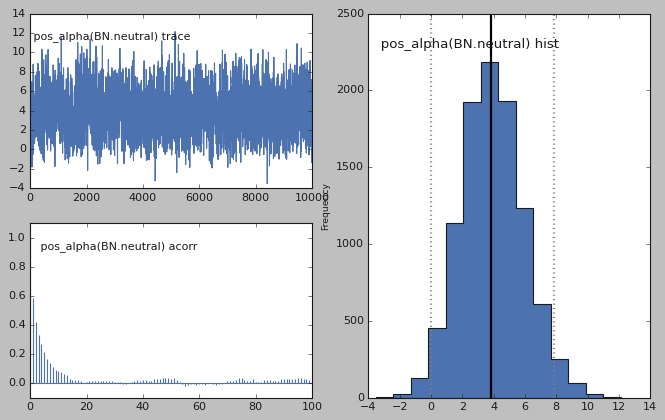

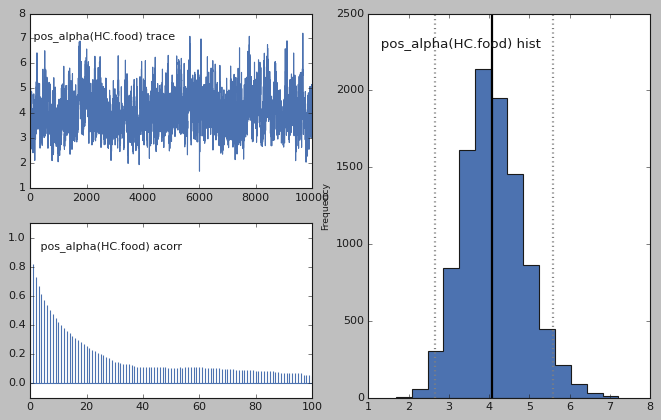

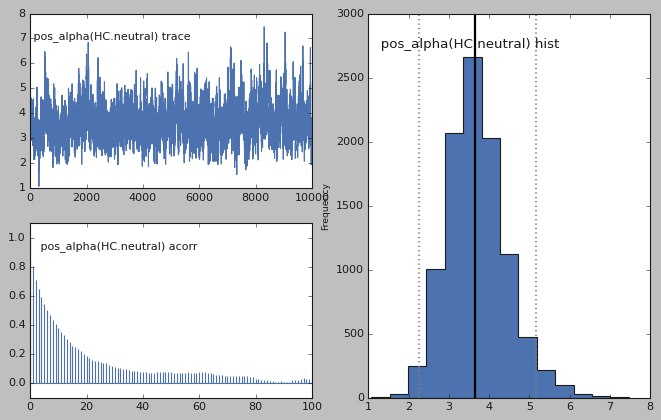

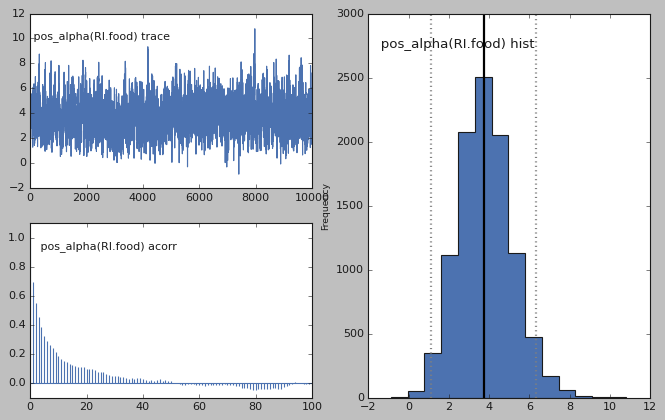

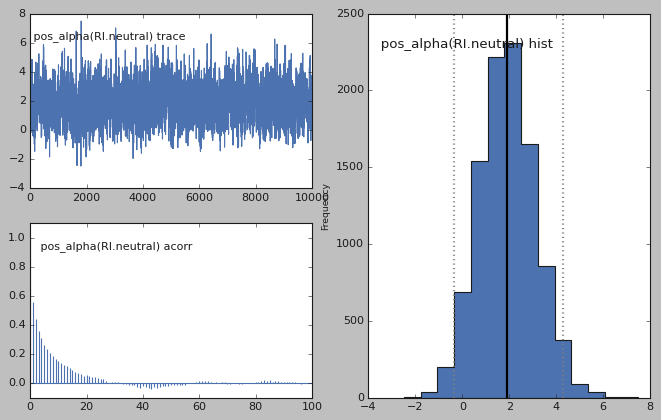

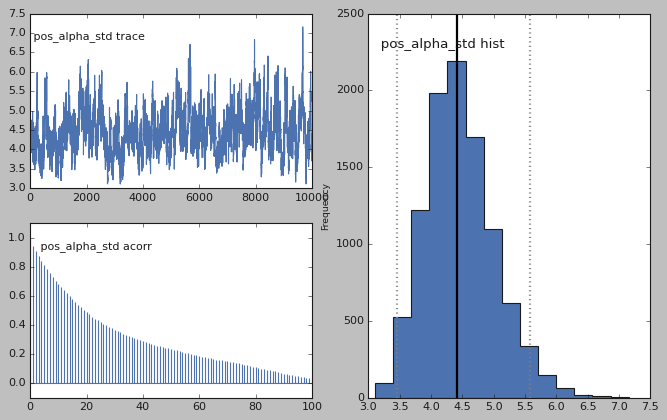

In [72]:
mod1.plot_posteriors()

### Estimate convergence


In [95]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        df,
        # bias=True,
        depends_on={
            'a': ['diag_cat', 'stim'],
            'v': ['diag_cat', 'stim'],
            't': ['diag_cat', 'stim'],
            'alpha': ['diag_cat', 'stim'],
            'pos_alpha': ['diag_cat', 'stim']
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True
    )
    m.sample(2000, burn=1000, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [--                6%                  ] 128 of 2000 complete in 263.2 secHalting at iteration  127  of  2000
Could not generate output statistics for pos_alpha_subj(HC.food).112
Could not generate output statistics for a_subj(HC.neutral).131
Could not generate output statistics for alpha_subj(RI.neutral).232
Could not generate output statistics for t_subj(HC.food).103
Could not generate output statistics for v_subj(HC.food).237
Could not generate output statistics for pos_alpha(AN.food)
Could not generate output statistics for a_subj(RI.neutral).64
Could not generate output statistics for alpha_subj(RI.neutral).272
Could not generate output statistics for v_subj(HC.food).248
Could not generate output statistics for pos_alpha_subj(HC.food).107
Could not generate output statistics for a_subj(HC.food).172
Could not generate output statistics for a_subj(HC.neutral).134
Could not generate output statistics for v_subj(AN.neut

TypeError: 'NoneType' object is not subscriptable

In [81]:
gel_rub = gelman_rubin(models)
str(gel_rub)

"{'a(AN.food)': 0.9999849456913603, 'a(AN.neutral)': 1.0004241672997611, 'a(BN.food)': 1.000399174602155, 'a(BN.neutral)': 0.9995573910711514, 'a(HC.food)': 1.0002595451363987, 'a(HC.neutral)': 1.00060900293982, 'a(RI.food)': 1.0019548850794917, 'a(RI.neutral)': 0.9999691119642453, 'a_std': 1.0012030138631485, 'a_subj(AN.food).1': 1.0025574140135305, 'a_subj(AN.food).6': 1.0010793131536035, 'a_subj(AN.food).7': 1.0021691318298838, 'a_subj(AN.food).9': 0.9998636186960108, 'a_subj(AN.food).10': 0.9995654097740448, 'a_subj(AN.food).11': 1.0001133940654419, 'a_subj(AN.food).12': 0.9995853146443462, 'a_subj(AN.food).13': 0.9999986089403702, 'a_subj(AN.food).18': 1.001820943811596, 'a_subj(AN.food).19': 1.0015767981588397, 'a_subj(AN.food).20': 1.0033193576191013, 'a_subj(AN.food).23': 1.0034323273467523, 'a_subj(AN.food).24': 1.0004417937216328, 'a_subj(AN.food).25': 1.0009997052141, 'a_subj(AN.food).26': 1.0051842882869293, 'a_subj(AN.food).28': 0.9999935729963046, 'a_subj(AN.food).29': 1.

In [82]:
np.max(list(gelman_rubin(models).values()))


1.0621460433018537

In [83]:
np.mean(list(gelman_rubin(models).values()))


1.0019492901157456

In [84]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)


Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what’s usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. Daw, 2011).


In [87]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n, pos_alpha_an_f, pos_alpha_an_n, pos_alpha_hc_f, pos_alpha_hc_n, t_an_f, t_an_n, t_hc_f, t_hc_n, a_an_f, a_an_n, a_hc_f, a_hc_n, v_an_f, v_an_n, v_hc_f, v_hc_n = m.nodes_db.node[[
    'alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)', 'alpha(HC.neutral)',
    'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)', 'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)',
    't(AN.food)', 't(AN.neutral)', 't(HC.food)', 't(HC.neutral)',
    'a(AN.food)', 'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)',
    'v(AN.food)', 'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'
]]


KeyError: "None of [Index(['alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)',\n       'alpha(HC.neutral)', 'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)',\n       'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)', 't(AN.food)',\n       't(AN.neutral)', 't(HC.food)', 't(HC.neutral)', 'a(AN.food)',\n       'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)', 'v(AN.food)',\n       'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'],\n      dtype='object')] are in the [index]"

In [86]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'alpha(HC.food)': alpha_hc_f.trace(),
    'alpha(HC.neutral)': alpha_hc_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    'pos_alpha(HC.food)': pos_alpha_hc_f.trace(),
    'pos_alpha(HC.neutral)': pos_alpha_hc_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    't(HC.food)': t_hc_f.trace(),
    't(HC.neutral)': t_hc_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'a(HC.food)': a_hc_f.trace(),
    'a(HC.neutral)': a_hc_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace(),
    'v(HC.food)': v_hc_f.trace(),
    'v(HC.neutral)': v_hc_n.trace()
}


In [87]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace()
}


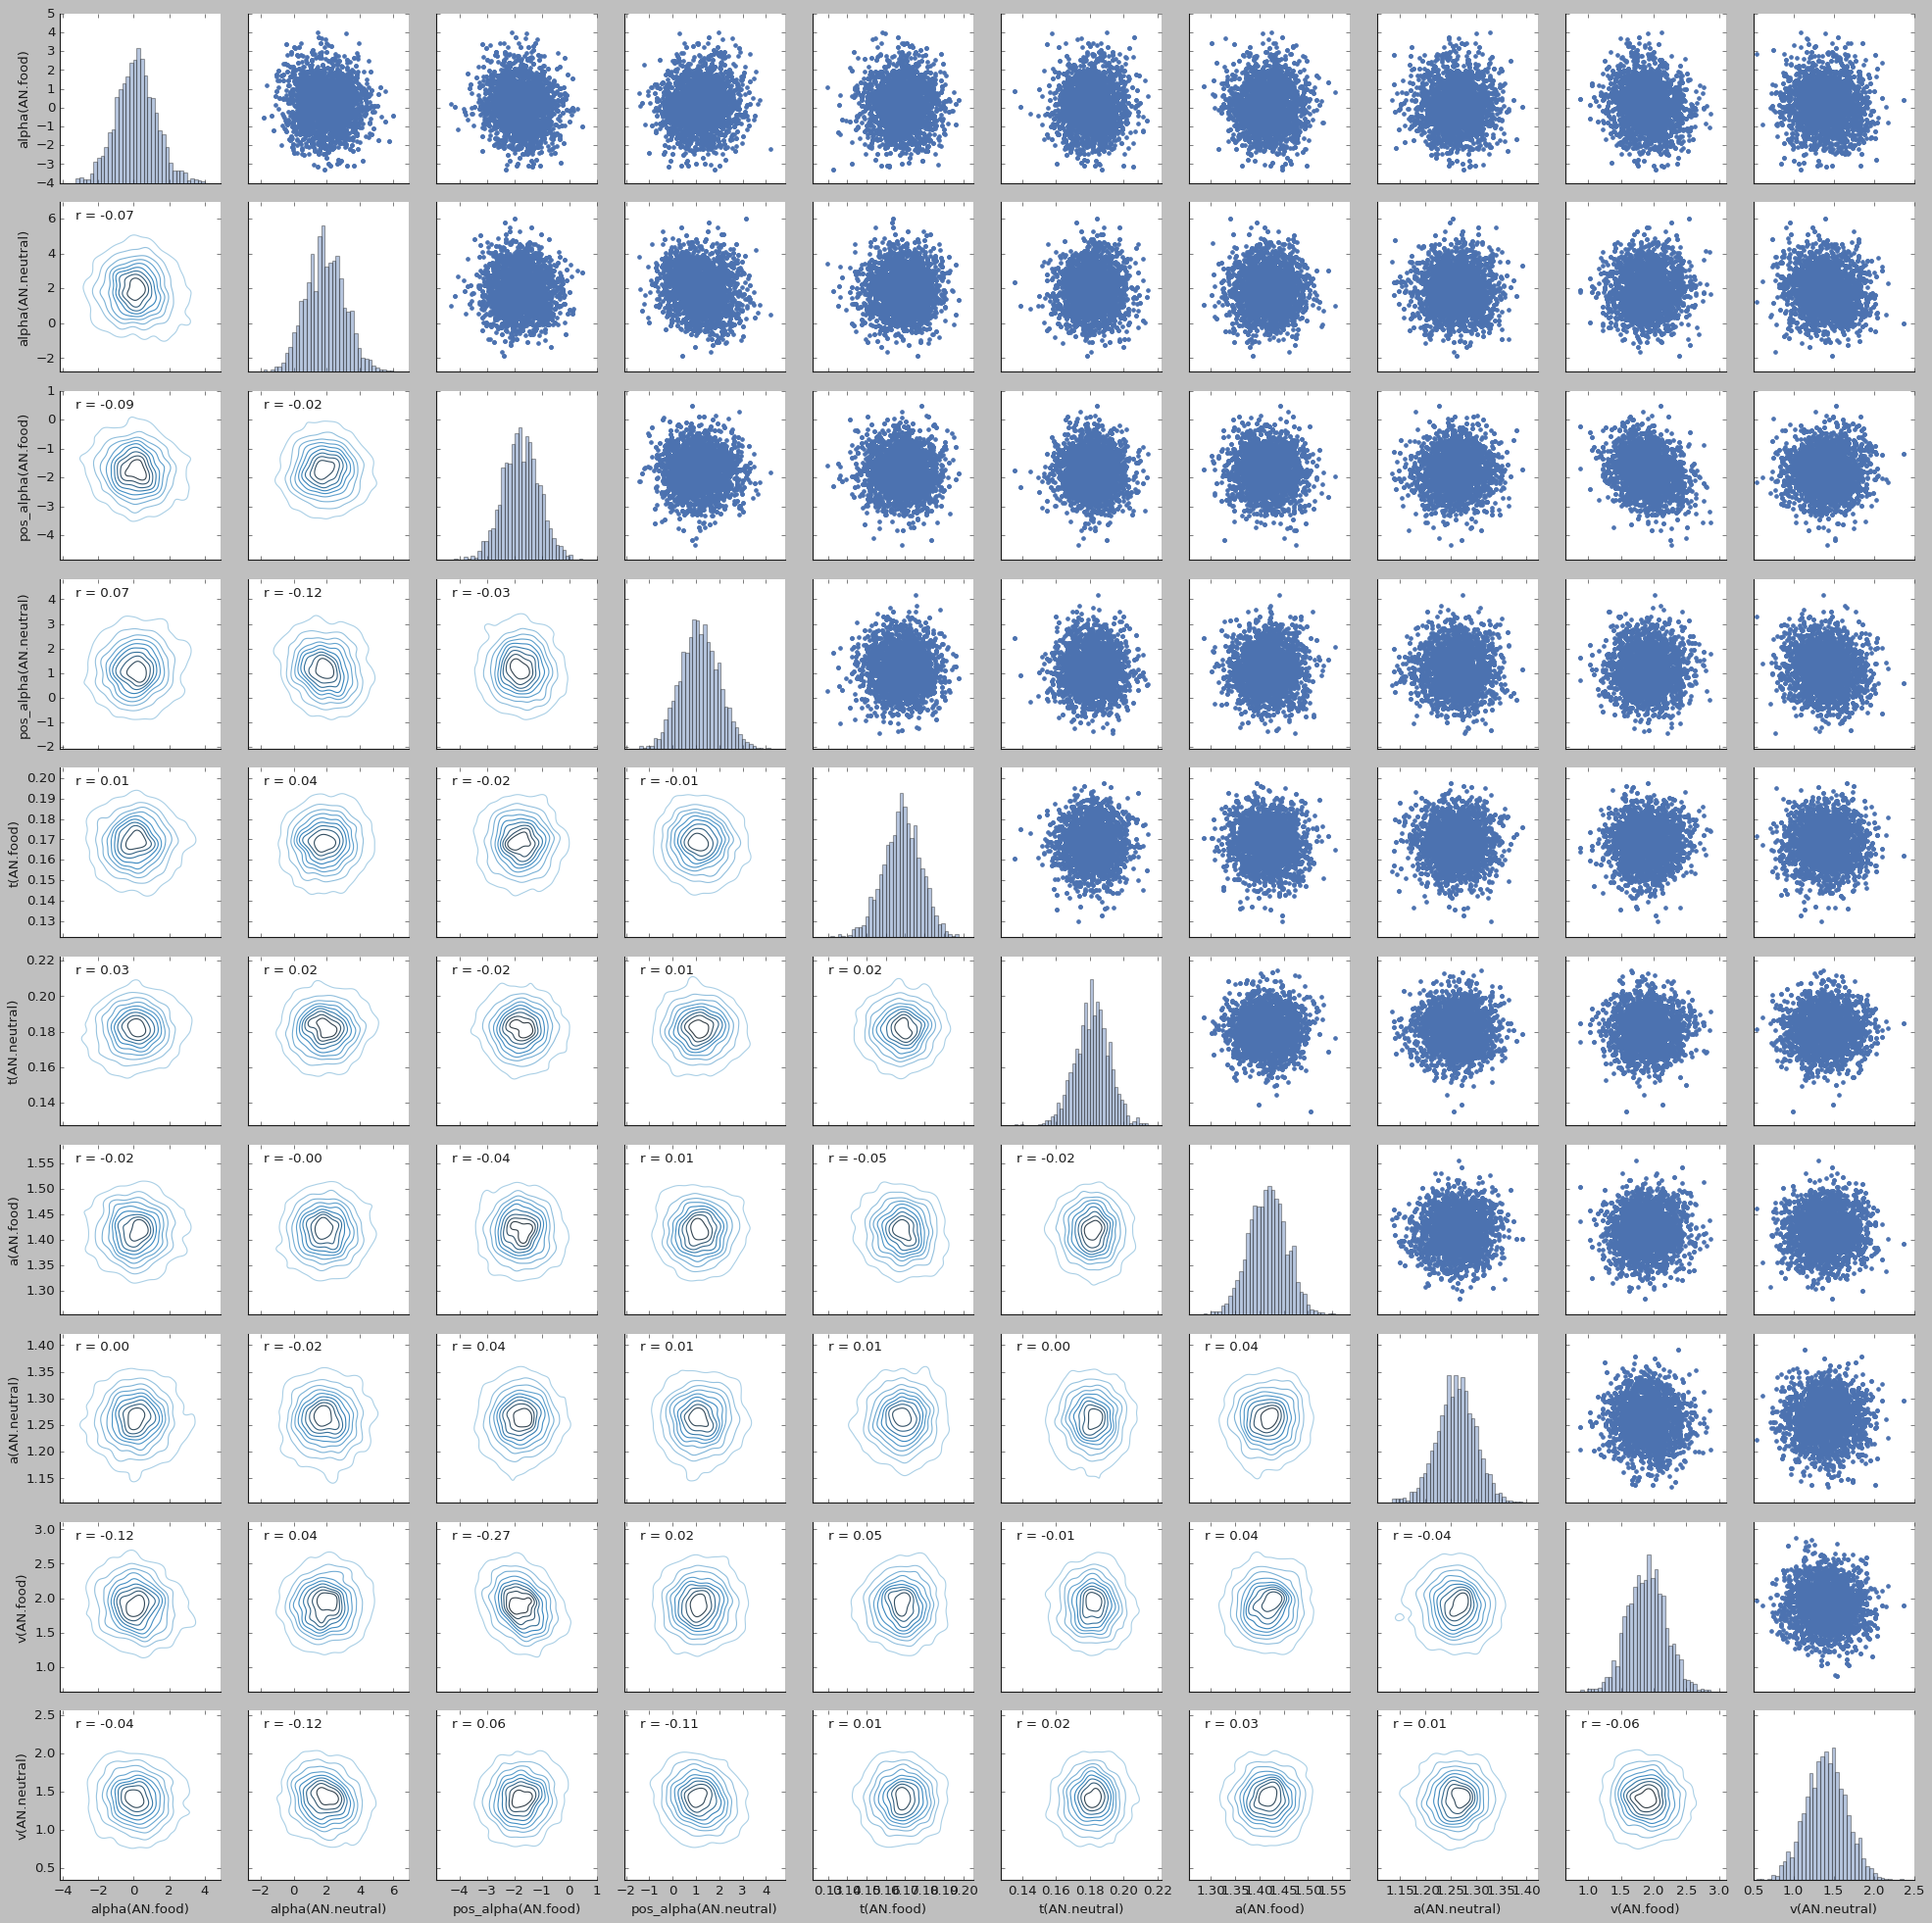

In [88]:
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')


## Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).


#### AN food


In [80]:
temp = df[
    (df.subj_code == "am_gu_1999_02_11_937_f") |  # AN
    (df.subj_code == "an_de_1998_11_10_289_f") |  # AN
    (df.subj_code == "gi_lo_2001_06_20_106_f") |  # HC
    (df.subj_code == "bi_ra_2000_09_28_341_f")   # HC
]

d = temp[(df.diag_cat == "AN")]
d.shape


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_3676/1633731404.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = temp[(df.diag_cat == "AN")]


(640, 10)

In [115]:
d = df

In [116]:
d["subj_idx"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,   0,
        27,  28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [83]:
# Change subj_idx
d.loc[d.subj_code == "am_gu_1999_02_11_937_f", "subj_idx"] = 0
d.loc[d.subj_code == "an_de_1998_11_10_289_f", "subj_idx"] = 1

d.head()


subj_idx  response     stim     rt  trial  split_by  feedback diag_cat  \
0         1         0     food  0.979      1         0         0       AN   
1         1         0  neutral  1.553      1         1         0       AN   
2         1         1     food  1.939      2         0         0       AN   
3         1         1  neutral  0.350      2         1         1       AN   
4         1         0     food  0.768      3         0         0       AN   

                subj_code  q_init  
0  ca_po_2002_05_25_700_f     0.5  
1  ca_po_2002_05_25_700_f     0.5  
2  ca_po_2002_05_25_700_f     0.5  
3  ca_po_2002_05_25_700_f     0.5  
4  ca_po_2002_05_25_700_f     0.5

In [117]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        d,
        # bias=True,
        p_outlier=0.05
    )
    m.sample(1000, burn=500, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1001 of 1000 complete in 1036.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1001 of 1000 complete in 1084.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1001 of 1000 complete in 1122.9 sec

In [103]:
# Combine the models
# m = kabuki.utils.concat_models(models)
traces = m.get_traces()
traces.head()


a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  1.323877  0.199476  1.482287  1.224995  1.039203  1.231765  1.696475   
1  1.311235  0.196302  1.472413  1.219104  1.037372  1.249166  1.611087   
2  1.314503  0.192492  1.493618  1.259879  1.014144  1.218965  1.549040   
3  1.316708  0.195648  1.397530  1.257920  1.031921  1.219508  1.584683   
4  1.326800  0.197732  1.399476  1.256341  1.002024  1.211395  1.603286   

   a_subj.5  a_subj.6  a_subj.7  ...  alpha_subj.287  alpha_subj.288  \
0  1.225957  1.253042  1.478611  ...       -2.679306        0.325121   
1  1.200089  1.295848  1.470522  ...       -2.960772        2.378370   
2  1.213164  1.266087  1.453933  ...       -2.332584       -1.297710   
3  1.216993  1.286115  1.447534  ...        3.684440       -3.282012   
4  1.118688  1.240731  1.494788  ...        0.742225        2.296837   

   alpha_subj.289  alpha_subj.290  alpha_subj.291  alpha_subj.292  \
0       -0.517257        3.790623        3.223801        1.392996   
1       -0.337207        3.154579        3.734984        1.503630   
2       -0.540394        2.025216        4.320375        4.674169   
3       -1.286727        5.019079        5.811092        2.177194   
4        0.629605        4.552476        3.226594        2.093802   

   alpha_subj.293  alpha_subj.294  alpha_subj.295  alpha_subj.296  
0       -3.507702        0.827445        2.415011        2.030943  
1        0.057655        0.681876        1.674439        0.254702  
2       -0.484561        0.767268        2.126917        2.037617  
3        3.078524        2.347753        4.936832        2.263950  
4        2.646953        0.849678        3.865630        1.710758  

[5 rows x 1188 columns]

In [104]:
traces.describe()

a       a_std    a_subj.0    a_subj.1    a_subj.2    a_subj.3  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.323489    0.206194    1.423137    1.233647    1.028272    1.208963   
std      0.014082    0.008923    0.042476    0.022335    0.036868    0.032166   
min      1.291850    0.186450    1.310761    1.183885    0.952892    1.132218   
25%      1.312679    0.198154    1.396781    1.214037    1.004571    1.187823   
50%      1.321825    0.206541    1.421367    1.234353    1.031326    1.212102   
75%      1.331941    0.211928    1.449666    1.250076    1.050872    1.228043   
max      1.357742    0.225752    1.517076    1.312391    1.120559    1.276533   

         a_subj.4    a_subj.5    a_subj.6    a_subj.7  ...  alpha_subj.287  \
count  100.000000  100.000000  100.000000  100.000000  ...      100.000000   
mean     1.595682    1.175550    1.274950    1.490286  ...        0.288234   
std      0.049035    0.039538    0.037657    0.036683  ...        2.329425   
min      1.453997    1.059110    1.197320    1.411658  ...       -4.642347   
25%      1.558584    1.144958    1.247433    1.463502  ...       -1.355171   
50%      1.597306    1.178313    1.275112    1.488487  ...        0.247504   
75%      1.627144    1.202802    1.299977    1.517088  ...        1.653010   
max      1.696475    1.257647    1.359471    1.609704  ...        5.751958   

       alpha_subj.288  alpha_subj.289  alpha_subj.290  alpha_subj.291  \
count      100.000000      100.000000      100.000000      100.000000   
mean        -0.959943       -0.476706        3.399069        4.383823   
std          2.841194        0.584862        1.699448        1.323055   
min         -6.290608       -1.870279       -1.111407        1.963671   
25%         -2.961628       -0.897871        2.269436        3.445233   
50%         -1.522600       -0.460154        3.412917        4.322433   
75%          1.084765       -0.084005        4.313046        5.241357   
max          5.531593        0.947395        8.282653        8.380700   

       alpha_subj.292  alpha_subj.293  alpha_subj.294  alpha_subj.295  \
count      100.000000      100.000000      100.000000      100.000000   
mean         1.843588        0.433032        1.975959        3.787093   
std          1.279366        3.148229        1.473071        1.383201   
min          0.036341       -6.729145       -0.171210        1.499037   
25%          0.935436       -2.714450        0.935570        2.603708   
50%          1.517264        0.963801        1.547988        3.618545   
75%          2.192806        2.700854        2.613283        4.832126   
max          7.088275        7.558963        9.317153        7.294230   

       alpha_subj.296  
count      100.000000  
mean         2.464004  
std          1.235661  
min         -0.010079  
25%          1.585176  
50%          2.282140  
75%          3.252594  
max          6.387289  

[8 rows x 1188 columns]

Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate pos*alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate* for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.


In [105]:
df1 = hddm.generate.gen_rand_rlddm_data(
    a=1.3,
    t=0.3,
    alpha=0.5,
    scaler=2,
    p_upper=0.7,
    p_lower=0.3,
    subjs=2,
    split_by=0,
    size=10
)


In [106]:
print(df1)


       q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       1.0  0.316488       0.0         0   
1  0.238837  0.500000  -0.533426       0.0  0.633488       0.0         0   
2  0.238837  0.238837   0.000000       0.0  0.638488       0.0         0   
3  0.238837  0.114086   0.254803       0.0  0.364488       0.0         0   
4  0.238837  0.054496   0.376516       1.0  0.271488       1.0         0   
5  0.636412  0.054496   1.188564       1.0  0.442488       1.0         0   
6  0.826324  0.054496   1.576458       1.0  0.820488       1.0         0   
7  0.917039  0.054496   1.761745       1.0  0.651488       0.0         0   
8  0.438046  0.054496   0.783400       0.0  0.492488       1.0         0   
9  0.438046  0.548358  -0.225312       0.0  0.291488       0.0         0   
0  0.500000  0.500000   0.000000       1.0  0.473136       0.0         1   
1  0.236118  0.500000  -0.505921       1.0  0.565136       1.0         1   
2  0.639267 

In [107]:
from tqdm import tqdm  # progress tracker
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
d['samp'] = 0
# load traces
traces = m.get_traces()


In [ ]:
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 10)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0]-1)
    # loop through all subjects in observed data
    for s in d.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 0)].trial.unique())
        size1 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 1)].trial.unique())
        # size2 = len(d[(d['subj_idx']==s) & (d['split_by']==2)].trial.unique())
        # set parameter values for simulation
        a = traces.loc[sample, 'a_subj.'+str(s)]
        t = traces.loc[sample, 't_subj.'+str(s)]
        scaler = traces.loc[sample, 'v_subj.'+str(s)]
        alphaInv = traces.loc[sample, 'alpha_subj.'+str(s)]
        # #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        # #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size0, p_upper=0.7, p_lower=0.3, split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size1, p_upper=0.7, p_lower=0.3, split_by=1)
        # #sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        # #append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # #assign subj_idx
        sim_data0['subj_idx'] = s
        # #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        # #identify the simulated data
        sim_data0['samp'] = i
        # #append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)


In [109]:
# combine observed and simulated data
ppc_data = d[['subj_idx', 'response', 'split_by',
              'rt', 'trial', 'feedback', 'samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx', 'response', 'split_by',
                      'rt', 'trial', 'feedback', 'type', 'samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')


In [110]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

In [111]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)).astype('int64')
# calculate means for each sample
sums = plot_ppc_data.groupby(
    ['bin_trial', 'split_by', 'samp', 'type']).mean().reset_index()
# calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial', 'split_by', 'type']).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial'] == ppc_sim.bin_trial[i]) & (
        sums['split_by'] == ppc_sim.split_by[i]) & (sums['type'] == ppc_sim.type[i])], alpha=0.1)
    ppc_sim.loc[i, 'upper_hpd'] = hdi[1]
    ppc_sim.loc[i, 'lower_hpd'] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')


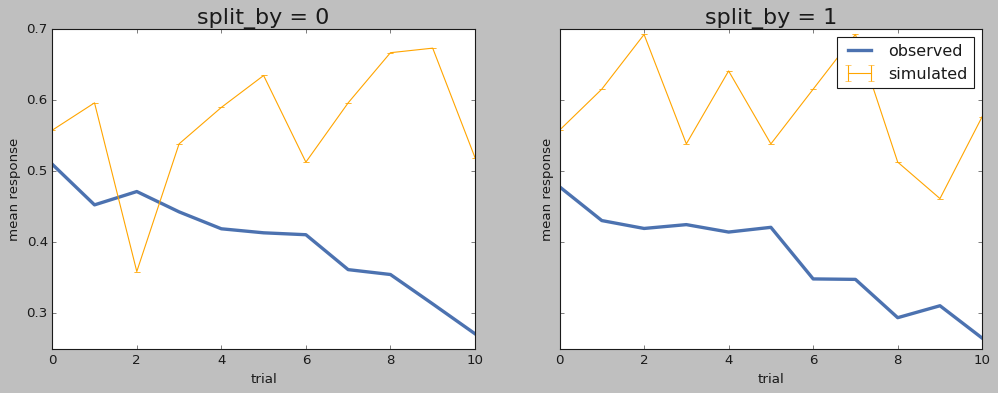

In [112]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1,
                        ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[
                d.low_err, d.up_err], label='simulated', color='orange')
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'observed')]
    ax.plot(d.bin_trial, d.response, linewidth=3, label='observed')
    ax.set_title('split_by = %i' % i, fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')


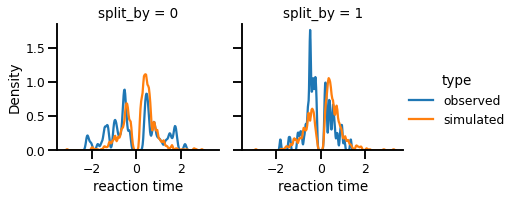

In [208]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(
    plot_ppc_data['response'] == 1, plot_ppc_data.rt, 0-plot_ppc_data.rt)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col='split_by', hue='type')
g.map(sns.kdeplot, 'reaction time', bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')


## Parameter recovery


In [ ]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')


## Simulating data

https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#posterior-predictive-checks


In [ ]:
traces = mod1.get_traces()
traces.head()

In [185]:
hddm.generate.gen_rand_rlddm_data(
    a=1,
    t=0.3,
    alpha=0.2,
    scaler=2,
    p_upper=0.8,
    p_lower=0.2,
    subjs=1,
    split_by=0,
    size=10,
)

q_up    q_low  sim_drift  response     rt  feedback  subj_idx  split_by  \
0  0.5000  0.50000    0.00000       1.0  0.403       0.0         0         0   
1  0.4000  0.50000   -0.20000       0.0  0.498       0.0         0         0   
2  0.4000  0.40000    0.00000       0.0  0.430       0.0         0         0   
3  0.4000  0.32000    0.16000       0.0  0.797       0.0         0         0   
4  0.4000  0.25600    0.28800       0.0  0.345       1.0         0         0   
5  0.4000  0.40480   -0.00960       1.0  0.392       1.0         0         0   
6  0.5200  0.40480    0.23040       1.0  1.056       1.0         0         0   
7  0.6160  0.40480    0.42240       0.0  0.454       0.0         0         0   
8  0.6160  0.32384    0.58432       1.0  0.410       0.0         0         0   
9  0.4928  0.32384    0.33792       1.0  0.433       1.0         0         0   

   trial  
0      1  
1      2  
2      3  
3      4  
4      5  
5      6  
6      7  
7      8  
8      9  
9     10

In [189]:
data1 = hddm.generate.gen_rand_rlddm_data(
    a=1, t=0.3, alpha=0.4, scaler=2, p_upper=0.8, p_lower=0.2, subjs=50, size=50
)
data1["group"] = "group1"
data2 = hddm.generate.gen_rand_rlddm_data(
    a=2, t=0.3, alpha=0.4, scaler=2, p_upper=0.8, p_lower=0.2, subjs=50, size=50
)
data2["group"] = "group2"
group_data = data1.append(data2)
group_data["q_init"] = 0.5
m = hddm.HDDMrl(
    group_data, depends_on={"v": "group", "a": "group", "t": "group", "alpha": "group"}
)
m.sample(1500, burn=500, dbname="traces.db", db="pickle")

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1500 of 1500 complete in 316.8 sec

In [190]:
mod1.print_stats()

                                    mean       std       2.5q       25q       50q       75q      97.5q    mc err
a(AN.food)                      1.415473  0.038792   1.338847  1.389686  1.415784  1.441908   1.491058  0.000462
a(AN.neutral)                    1.25971  0.037977   1.186143  1.234392  1.259601  1.285442   1.334457  0.000435
a(BN.food)                      1.439834  0.065823   1.308936  1.395298  1.441424  1.484472   1.567022  0.000801
a(BN.neutral)                    1.22915  0.071689   1.085583  1.181153  1.230349  1.278117   1.368265  0.000671
a(HC.food)                      1.339932  0.015916   1.308528  1.329339   1.34004  1.350598   1.370901  0.000178
a(HC.neutral)                   1.257598  0.016515   1.225905  1.246365  1.257431  1.268563   1.290826  0.000185
a(RI.food)                      1.388596  0.039269   1.311919  1.362102  1.388923    1.4154   1.463125  0.000445
a(RI.neutral)                   1.264549  0.041682   1.182586  1.235972  1.264405  1.293466   1.

In [211]:
data_f = hddm.generate.gen_rand_rlddm_data(
    a=1.4, t=0.2, alpha=.1, scaler=1.9, p_upper=0.7, p_lower=0.3, subjs=35, size=160
)
data_f["group"] = "food"

data_n = hddm.generate.gen_rand_rlddm_data(
    a=1.2, t=0.2, alpha=.85, scaler=1.4, p_upper=0.7, p_lower=0.3, subjs=35, size=160
)
data_n["group"] = "neutral"

group_data = data_f.append(data_n)
group_data["q_init"] = 0.5

In [212]:
group_data.head()

q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       0.0  0.439573       0.0         0   
1  0.500000  0.499500   0.000849       1.0  0.238573       1.0         0   
2  0.500500  0.499500   0.001698       1.0  0.226573       1.0         0   
3  0.500999  0.499500   0.002547       0.0  0.189573       0.0         0   
4  0.500999  0.499001   0.003395       0.0  0.684573       0.0         0   

   split_by  trial group  q_init  
0         0      1  food     0.5  
1         0      2  food     0.5  
2         0      3  food     0.5  
3         0      4  food     0.5  
4         0      5  food     0.5

In [213]:
m = hddm.HDDMrl(
    group_data, depends_on={"alpha": "group"},
    p_outlier=0.05,
    informative=True,
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [214]:
m.sample(1500, burn=500, dbname="traces.db", db="pickle")


 [-----------------100%-----------------] 1500 of 1500 complete in 359.6 sec

In [210]:
m.print_stats()

                             mean       std       2.5q        25q        50q        75q      97.5q    mc err
a                        1.497475  0.116497   1.282037   1.420237   1.496201   1.568493   1.751217  0.005498
a_std                    0.676428  0.101398   0.510023   0.606795   0.662649   0.735228   0.914419  0.005553
a_subj.0                 3.444373  0.088517   3.282332   3.379546   3.440898   3.503944   3.627563  0.003642
a_subj.1                 1.032839  0.044721   0.945295   1.002131   1.030898   1.062975   1.123832  0.001891
a_subj.2                 1.114335  0.048244    1.02663   1.081308   1.112458    1.14234   1.224361   0.00246
a_subj.3                  1.04374  0.045271   0.957141   1.013731   1.043437   1.071998   1.139331  0.002205
a_subj.4                 1.212726  0.050342    1.11575   1.180697   1.212216   1.242629   1.320814  0.002237
a_subj.5                 1.095959  0.043555   1.015636   1.064855   1.095345   1.125321   1.184762  0.001923
a_subj.6           